In [1]:
from src.data.data_retriever import DataRetriever
from utils.odoo_connector import OdooConnection
import asyncio
import nest_asyncio
from forex_python.converter import CurrencyRates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
nest_asyncio.apply()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
def odoo_missing_values_to_null(df):
    object_cols = df.select_dtypes(include='object').columns
    print(object_cols)
    df[object_cols] = (df[object_cols].replace({False: pd.NA, '' : pd.NA, '/' : pd.NA}))
    df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)
    return df

In [4]:
def convert_to_datetime(df, columns):
    for col in columns:
        try:
            # formato que no soporta nativamente to_datetime
            if df[col].astype(str).str.contains('/').any():
                df[col] = pd.to_datetime(df[col], errors='coerce', format='%d/%m/%Y')
            else:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        except Exception as e:
            print(f"Error al convertir '{col}': {e}")
    return df

In [5]:
def check_invalid_date_format(series, date_format='%d/%m/%Y'):
    invalid = []
    for val in series.dropna():
        val = str(val).strip()
        if val == '' or val.lower() == 'false':
            continue
        try:
            datetime.strptime(val, date_format)
        except ValueError:
            invalid.append(val)
    return pd.Series(invalid).drop_duplicates().reset_index(drop=True)

# Exploración de los datos

# 1. Estructura de la base de datos

## 1.1. Modelos relevantes

En está sección describo los distintos modelos que deberán ser utilizados. 

También he seleccionado los campos que pueden llegar a ser importantes para el desarrollo. Cabe remarcar que con "importantes", no me refiero únicamente para entrenar el modelo de predicción de impagos, también tengo en cuenta información que el agente podría necesitar.

### 1.1.1. res.company

Contiene información sobre las empresas que forman el grupo (no clientes):
- id
- name
- currency_id (Identificador de la moneda [id, nombre])

### 1.1.2. res.partner

Contiene información sobre los partners (clientes/proveedores):
- id
- name
- email
- phone
- street
- city
- zip
- country_id
- customer_rank (>0 es cliente)
- supplier_rank (>0 es proveedor)
- category_id (sector/industria a la que pertenece)
- is_company
- company_type
- company_id
- credit
- credit_limit
- debit
- debit_limit
- industry_id
- invoice_ids
- total_due
- total_invoiced
- total_overdue
- trust
- unpaid_invoice_ids
- unpaid_invoices_count

### 1.1.3. account.move

Guarda todas las facturas y movimientos contables de la empresa, es decir, los registros de todo lo que se compra, se vende o se paga. Este será el modelo principal con el que trabajará el agente:
- id
- name
- move_type ("out_invoice", "in_invoice", "out_refund", "in_refund", "entry")
- payment_state ("not_paid", "in_payment", "paid", "partial", "reversed")
- company_id
- partner_id
- currency_id
- amount_total
- amount_paid
- amount_residual
- invoice_date
- invoice_date_due
- payment_dates
- date
- create_date
- payment_id
- payment_ids

### 1.1.4. res.currency

Contiene información sobre las monedas en las que se emiten facturas y se registran los movimientos:
- id
- name
- symbol
- rate

### 1.1.5. res.country

Contiene información sobre los países:
- id
- name
- code

### 1.1.6. res.partner.category

Representa las categorías asignadas a los partners:
- id
- name

### 1.1.7. res.partner.industry

Contiene información de la industria / sector económico de los partners:
- id
- name

## 1.2. Exploración y limpieza de los datos

#### Conexión a Odoo

In [5]:
all_invoices = pd.read_pickle('all_invoices.pkl')
all_invoices['move_type'].value_counts()

move_type
entry          111574
out_invoice     24293
in_invoice      22930
in_refund         541
out_refund        467
in_receipt         26
Name: count, dtype: int64

In [2]:
odoo_connection = OdooConnection()
data_retriever = DataRetriever(odoo_connection=odoo_connection)
asyncio.run(odoo_connection.connect())


Connected to Odoo as albert.gil@yourtechtribe.com (uid: 430)
Odoo server version: {'server_version': '16.0+e-20250313', 'server_version_info': [16, 0, 0, 'final', 0, 'e'], 'server_serie': '16.0', 'protocol_version': 1}


In [8]:
invoices_payment_term_ids = asyncio.run(odoo_connection.search_read(model='account.move', domain=[('move_type', '=', 'out_invoice')], fields=['invoice_payment_term_id']))

In [3]:
#company_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_companies()))
#all_invoices_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_invoices()))
outbound_invoices_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_outbound_invoices()))
partners_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_customer_partners()))
#partners_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_customer_partners()))
#currencies_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_currencies()))
#partner_categories_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_partner_categories()))
#industrys_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_industries()))
#invoice_lines_df_original = pd.DataFrame(asyncio.run(data_retriever.get_all_lines_of_all_outbound_invoices()))

Recuperadas 500 facturas, total: 500
Recuperadas 500 facturas, total: 3000
Recuperadas 500 facturas, total: 5500
Recuperadas 500 facturas, total: 8000
Recuperadas 500 facturas, total: 10500
Recuperadas 500 facturas, total: 13000
Recuperadas 500 facturas, total: 15500
Recuperadas 500 facturas, total: 18000
Recuperadas 500 facturas, total: 20500
Recuperadas 500 facturas, total: 23000
Recuperadas 500 facturas, total: 500


In [4]:
outbound_invoices_df_original.to_pickle('outbound_invoices.pkl')
partners_df_original.to_pickle('partners.pkl')

In [5]:
pd.set_option('display.max_columns', None)
X = pd.read_pickle('data/X_auto.pkl')
y = pd.read_pickle('data/y_auto.pkl')
agent_dataset = pd.read_pickle('data/agent_dataset_auto.pkl')

In [8]:
agent_dataset[1000:1020]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name,amount_total_eur,amount_residual_eur,payment_overdue_days,term_rounded,due_last_three_days_month,due_date_second_half_month,avg_invoiced_prior,num_prior_invoices,num_late_prior_invoices,ratio_late_prior_invoices,total_invoice_amount_prior,total_invoice_amount_late_prior,ratio_invoice_amount_late_prior,avg_delay_prior_late_invoices,avg_delay_prior_all,num_outstanding_invoices,num_outstanding_invoices_late,ratio_outstanding_invoices_late,total_invoice_amount_outstanding,total_invoice_amount_outstanding_late,ratio_invoice_amount_outstanding_late,avg_payment_term_prior_invoices,paid_late,payment_overdue_category
1000,189123,AMZN-2025-030,out_invoice,not_paid,3,9308.000,1,9.000,9.000,2025-02-02,2025-02-17,NaT,Elogia Media S.L.,AMAZON INVOICING SPAIN,EUR,9.000,9.000,NaN,0,False,True,201.668,136.000,78.000,0.574,27426.870,25788.590,0.940,56.769,27.191,78.000,78.000,1.000,1278.450,1278.450,1.000,10.368,False,None
1001,194845,STR/2025/00015,out_invoice,paid,11,9889.000,1,12.500,0.000,2025-02-02,2025-02-02,2025-02-02,"DigitalPla2021, S.L.",Felicidad Ortiz,EUR,12.500,0.000,0.000,0,False,False,12.500,25.000,1.000,0.040,312.500,12.500,0.040,5.000,0.200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,False,Puntual
1002,194846,STR/2025/00014,out_invoice,paid,11,9913.000,1,9.000,0.000,2025-02-02,2025-02-02,2025-02-02,"DigitalPla2021, S.L.",Sara Carbajo,EUR,9.000,0.000,0.000,0,False,False,9.000,24.000,1.000,0.042,216.000,9.000,0.042,5.000,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,False,Puntual
1003,194740,INT/2025/00002,out_invoice,not_paid,1,10.000,1,131605.930,131605.930,2025-02-01,2025-03-12,NaT,"Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR,131605.930,131605.930,NaN,30,False,False,31599.726,87.000,68.000,0.782,2749176.130,2257144.200,0.821,340.853,258.425,26.000,22.000,0.846,220169.760,209689.720,0.952,52.931,False,None
1004,194742,INT/2025/00003,out_invoice,not_paid,1,13260.000,1,67427.290,67427.290,2025-02-01,2025-03-12,NaT,"Grupo Viko Digital Marketing, S.A.",Ideas y Estrategia Digital SL,EUR,67427.290,67427.290,NaN,30,False,False,11092.225,4.000,4.000,1.000,44368.900,44368.900,1.000,31.000,31.000,2.000,2.000,1.000,64030.100,64030.100,1.000,7.500,False,None
1005,194734,INT/2025/00001,out_invoice,not_paid,14,10.000,1,41964.870,41964.870,2025-02-01,2025-03-12,NaT,Ideas y Estrategia Digital SL,Elogia Media S.L.,EUR,41964.870,41964.870,NaN,30,False,False,31599.726,87.000,68.000,0.782,2749176.130,2257144.200,0.821,340.853,258.425,26.000,22.000,0.846,220169.760,209689.720,0.952,52.931,False,None
1006,184590,FVI/2025/00019,out_invoice,not_paid,14,13548.000,1,235.950,235.950,2025-01-31,2025-04-01,NaT,Ideas y Estrategia Digital SL,Esteve Pharmaceuticals SA,EUR,235.950,235.950,NaN,60,False,False,8513.042,91.000,12.000,0.132,774686.860,99540.650,0.128,7.500,-16.956,6.000,6.000,1.000,62436.740,62436.740,1.000,59.341,False,None
1007,185322,FVI/2025/00028,out_invoice,not_paid,14,7583.000,1,31460.000,31460.000,2025-01-31,2025-05-15,NaT,Ideas y Estrategia Digital SL,"Reckitt Benckiser Healthcare, S.A.",EUR,31460.000,31460.000,NaN,120,False,False,8760.400,3.000,3.000,1.000,26281.200,26281.200,1.000,73.000,73.000,3.000,0.000,0.000,47371.500,0.000,0.000,60.000,False,None
1008,184228,FVI/2025/00002,out_invoice,not_paid,2,7854.000,1,11918.650,11918.650,2025-01-31,2025-04-01,NaT,Ibrands Medios Interactivos SL,Merkal Calzados S.L.,EUR,11918.650,11918.650,NaN,60,False,False,13344.798,24.000,24.000,1.000,320275.150,320275.150,1.000,29.333,29.333,2.000,2.000,1.000,16893.700,16893.700,1.000,58.125,False,None
1009,182657,FVE/2025/00049,out_invoice,not_paid,3,8199.000,1,1996.500,1996.500,2025-01-31,2025-04-01,NaT,Elogia Media S.L.,"Unidad Editorial Formación, S.L.U.",EUR,1996.500,1996.500,NaN,60,False,False,8271.458,33.000,33.000,1.000,272958.120,272958.120,1.000,61.939,61.939

In [7]:
invoice_lines_df_original.to_pickle("invoice_lines.pkl")

In [7]:
#company_df_original.to_pickle("companies.pkl")
#invoices_df_original.to_pickle("invoices.pkl")
#partners_df_original.to_pickle("partners.pkl")
all_invoices_df_original.to_pickle("all_invoices.pkl")
#currencies_df_original.to_pickle("currencies.pkl")
#partner_categories_df_original.to_pickle("partner_categories.pkl")
#industrys_df_original.to_pickle("industries.pkl")  

In [6]:
invoices_df = pd.read_pickle("invoices.pkl")
company_df = pd.read_pickle("companies.pkl")
partners_df = pd.read_pickle("partners.pkl")
currencies_df = pd.read_pickle("currencies.pkl")
partner_categories_df = pd.read_pickle("partner_categories.pkl")
industries_df = pd.read_pickle("industries.pkl")

In [123]:
invoices_df = invoices_df_original.copy()
company_df = company_df_original.copy()
partners_df = partners_df_original.copy()
currencies_df = currencies_df_original.copy()
partner_categories_df = partner_categories_df_original.copy()

NameError: name 'company_df_original' is not defined

In [ ]:
invoices_df = pd.read_csv
company_df = company_df_original.copy()
partners_df = partners_df_original.copy()
currencies_df = currencies_df_original.copy()
partner_categories_df = partner_categories_df_original.copy()

### 1.2.1. res.company

In [46]:
company_df

,id,name,currency_id
0,1,"Grupo Viko Digital Marketing, S.A.","[1, EUR]"
1,3,Elogia Media S.L.,"[1, EUR]"
2,2,Ibrands Medios Interactivos SL,"[1, EUR]"
3,5,Kraz Data Solutions SL,"[1, EUR]"
4,6,Marketing4ecommerce Digital Content SL,"[1, EUR]"
5,13,Octoplus Digital Shelf Optimization SL,"[1, EUR]"
6,7,Tandem Trade Marketing SL,"[1, EUR]"
7,11,"DigitalPla2021, S.L.","[1, EUR]"
8,14,Ideas y Estrategia Digital SL,"[1, EUR]"
9,8,INICIATIVAS VIRTUALES DE MEXICO,"[33, MXN]"


El grupo está formado por 12 empresas, 9 usan el euro y 3 el peso mexicano.

### 1.2.2. account.move

#### Inspección inicial

In [40]:
invoices_df.head(7000)

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
0,198507,403-0199881-4444363,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-10,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
1,198549,FVM/2025/00068,out_invoice,not_paid,6,14913,1,121.000,121.000,2025-11-07,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
3,198522,ES501155NOOJRS,out_invoice,not_paid,7,1,1,116.160,116.160,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
4,198516,ES501152NOOJRS,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
6,198471,FVM/2025/00067,out_invoice,not_paid,6,8870,1,2420.000,2420.000,2025-11-05,2025-11-05,<NA>,Marketing4ecommerce Digital Content SL,Hero España SA,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,174681,INV-FR-476254813-2024-347,out_invoice,paid,7,13924,1,10.200,0.000,2024-12-01,2024-12-16,03/12/2024,Tandem Trade Marketing SL,Marketplaces Francia,EUR
7038,174697,INV-FR-476254813-2024-346,out_invoice,paid,7,13924,1,10.200,0.000,2024-12-01,2024-12-16,03/12/2024,Tandem Trade Marketing SL,Marketplaces Francia,EUR
7039,174664,INV-DE-476254813-2024-74,out_invoice,paid,7,13925,1,15.910,0.000,2024-12-01,2024-12-16,03/12/2024,Tandem Trade Marketing SL,Marketplaces Alemania,EUR
7040,174701,INV-DE-476254813-2024-73,out_invoice,paid,7,10892,1,19.820,0.000,2024-12-01,2024-12-16,03/12/2024,Tandem Trade Marketing SL,Marketplaces España,EUR


A simple vista se puede apreciar:
- Se deben convertir los valores '', [] y False (en columnas no booleanas) a NA
- Facturas sin nombre o con formatos muy diferentes
- Las últimas facturas aparecen impagadas por ser demasiado recientes
- Parece que hay algunos campos que no tienen fecha de la factura
- payment_id y payment_ids parecen no tener nada

Convierto los valores False / listas vacías a valores NA

In [9]:
invoices_df = odoo_missing_values_to_null(invoices_df)

Index(['name', 'move_type', 'payment_state', 'company_id', 'partner_id',
       'currency_id', 'invoice_date', 'invoice_date_due', 'payment_dates',
       'date', 'create_date', 'payment_ids'],
      dtype='object')


C:\Users\Ismae\AppData\Local\Temp\ipykernel_26296\434508603.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)


In [10]:
invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                24288 non-null  int64  
 1   name              24248 non-null  object 
 2   move_type         24288 non-null  object 
 3   payment_state     24288 non-null  object 
 4   company_id        24288 non-null  object 
 5   partner_id        24280 non-null  object 
 6   currency_id       24288 non-null  object 
 7   amount_total      24288 non-null  float64
 8   amount_paid       24288 non-null  float64
 9   amount_residual   24288 non-null  float64
 10  invoice_date      24276 non-null  object 
 11  invoice_date_due  24288 non-null  object 
 12  payment_dates     19048 non-null  object 
 13  date              24288 non-null  object 
 14  create_date       24288 non-null  object 
 15  payment_id        24288 non-null  bool   
 16  payment_ids       0 non-null      float6

Analizando los valores null:
- payment_ids es todo null
- Hay 12 facturas sin fecha, 8 sin información sobre el cliente y 40 sin nombre
- Varias facturas sin fecha del pago (impagadas o recientes)

A simple vista, date, create_date, payment_id y payment_ids no son de utilidad, las dos primeras no aportan ninguna información, ya tengo invoice_date, invoice_date_due y payment_dates y las dos últimas son todo False y NA.

In [11]:
invoices_df = invoices_df.drop(columns=['date', 'create_date', 'payment_id', 'payment_ids'])

Las listas company_id, partner_id y currency_id, las separaré en dos columnas cada una

In [12]:
invoices_df['company_name'] = invoices_df['company_id'].apply(lambda x: x[1])
invoices_df['company_id'] = invoices_df['company_id'].apply(lambda x: x[0])

In [13]:
invoices_df['partner_name'] = invoices_df['partner_id'].apply(lambda x: x[1] if isinstance(x, list) else pd.NA)
invoices_df['partner_id'] = invoices_df['partner_id'].apply(lambda x: x[0] if isinstance(x, list) else pd.NA)
invoices_df['currency_name'] = invoices_df['currency_id'].apply(lambda x: x[1])
invoices_df['currency_id'] = invoices_df['currency_id'].apply(lambda x: x[0])

In [14]:
invoices_df.head(10000)

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_paid,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
0,198507,403-0199881-4444363,out_invoice,not_paid,7,1,1,43.560,0.000,43.560,2025-11-10,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
1,198549,FVM/2025/00068,out_invoice,not_paid,6,14913,1,121.000,0.000,121.000,2025-11-07,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
2,198548,<NA>,out_invoice,not_paid,6,14913,1,726.000,0.000,726.000,<NA>,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
3,198522,ES501155NOOJRS,out_invoice,not_paid,7,1,1,116.160,0.000,116.160,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
4,198516,ES501152NOOJRS,out_invoice,not_paid,7,1,1,43.560,0.000,43.560,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,158574,RECEIPT-IT-476254813-2024-791,out_invoice,paid,7,13926,1,11.990,0.000,0.000,2024-10-07,2024-10-22,22/10/2024,Tandem Trade Marketing SL,Marketplaces Italia,EUR
9996,158560,RECEIPT-IT-476254813-2024-790,out_invoice,paid,7,13926,1,11.990,0.000,0.000,2024-10-07,2024-10-22,22/10/2024,Tandem Trade Marketing SL,Marketplaces Italia,EUR
9997,158563,RECEIPT-IT-476254813-2024-789,out_invoice,paid,7,13926,1,11.990,0.000,0.000,2024-10-07,2024-10-22,22/10/2024,Tandem Trade Marketing SL,Marketplaces Italia,EUR
9998,158570,RECEIPT-IT-476254813-2024-788,out_invoice,paid,7,13926,1,11.990,0.000,0.000,2024-10-07,2024-10-22,07/10/2024,Tandem Trade Marketing SL,Marketplaces Italia,EUR


In [15]:
invoices_df["id"].duplicated().sum()

np.int64(0)

No hay duplicados

In [14]:
invoices_df.nunique()

id                  24288
name                23746
move_type               1
payment_state           5
company_id             12
partner_id           1549
currency_id             6
amount_total         6836
amount_paid             1
amount_residual       861
invoice_date          981
invoice_date_due     1091
payment_dates         817
company_name           12
partner_name         1548
currency_name           6
dtype: int64

Se puede apreciar:
- Varios nombres de facturas vacíos y duplicados como se ha visto antes
- Aunque las empresas trabajan con dos monedas internamente, han operado con clientes en 6 monedas diferentes, habrá que hacer las conversiones
- Parece que amount_paid no tiene ningún valor (0) por tanto, tampoco aporta ninguna información, amount_residual ya tiene lo que falta por pagar, se puede inferir la cantidad pagada
- Todos los otros campos corresponden a lo esperado

#### amount_paid

In [15]:
invoices_df['amount_paid'].mean()

np.float64(0.0)

In [21]:
invoices_df = invoices_df.drop(columns=['amount_paid'])

#### name

Todas las facturas sin nombre no han sido pagadas

In [22]:
invoices_na_name = invoices_df[invoices_df["name"].isna()]

In [23]:
invoices_na_name.head()

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
2,198548,<NA>,out_invoice,not_paid,6,14913,1,726.000,726.000,<NA>,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
5,198515,<NA>,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
10,198444,<NA>,out_invoice,not_paid,6,15058,1,60.500,60.500,<NA>,2025-11-28,<NA>,Marketing4ecommerce Digital Content SL,"Banbu Cosmética Natural, S.L.",EUR
1134,197217,<NA>,out_invoice,not_paid,7,10892,1,1.000,1.000,2025-07-28,2025-08-12,<NA>,Tandem Trade Marketing SL,Marketplaces España,EUR
1793,196524,<NA>,out_invoice,not_paid,7,14617,1,12.200,12.200,<NA>,2025-06-05,<NA>,Tandem Trade Marketing SL,Marketplaces EMPRESA Italia,EUR


In [24]:
for col in invoices_na_name.columns:
    print(f"Columna: {col}")
    print(invoices_na_name[col].unique())

Columna: id
[198548 198515 198444 197217 196524 196523 196186 196144 195208 195203
 195137 195020 194558 194555 194552 193263 192960 192730 192721 192712
 192709 192706 192700 192697 192694 192682 192658 192655 192629 192628
 192623 189566 195202 195200 189531 182747 181419 179523  49220  45100]
Columna: name
[<NA>]
Columna: move_type
['out_invoice']
Columna: payment_state
['not_paid']
Columna: company_id
[6 7 3 8 1]
Columna: partner_id
[14913 1 15058 10892 14617 8571 8996 12056 8870 13043 12537 11041 13567
 9759 10566 11187 11184 13904 11185 11186 9957 8960 14937 <NA> 8679 12100]
Columna: currency_id
[ 1 33  2]
Columna: amount_total
[7.2600000e+02 4.3560000e+01 6.0500000e+01 1.0000000e+00 1.2200000e+01
 1.0000000e+01 0.0000000e+00 4.6400000e+04 4.5820000e+04 1.0035000e+04
 9.2800000e+03 3.4800000e+03 1.3920000e+05 6.3644966e+05 4.0600000e+04
 7.0800000e+02 1.4140000e+03 7.6137760e+04 1.2760000e+05 1.1488524e+05
 9.2624840e+04 9.8901600e+03 2.7980360e+04 7.0794800e+04 1.0440000e+05
 1.

Parece ser que todas las facturas sin nombre, son pruebas o drafts de facturas que no llegaron a venta, por tanto se pueden eliminar:

In [25]:
size_na_name = len(invoices_na_name)
count_no_invoice = 0
count_draft_invoice = 0
invoices_no_draft = []
for id in invoices_na_name['id']:
    lines = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(invoice_id=id))
    if len(lines) > 0:
        if 'Draft Invoice' in lines[0]['move_id'][1]:
            count_draft_invoice += 1
        else:
            invoices_no_draft.append(lines)
    else:
        count_no_invoice += 1
print(f"Total invoices with NA name: {size_na_name}")
print(f"Invoices with no invoice lines: {count_no_invoice}")
print(f"Invoices with draft invoice lines: {count_draft_invoice}")
print(f"Invoices with invoice lines but no draft: {len(invoices_no_draft)}")
invoices_no_draft[0]

Total invoices with NA name: 40
Invoices with no invoice lines: 3
Invoices with draft invoice lines: 34
Invoices with invoice lines but no draft: 3


[{'id': 646426,
  'move_id': [195203, '(* 195203) (Pruebas)'],
  'product_id': [46, '[AMAZON DSP (ELOGIA)] AMAZON DSP'],
  'quantity': 1.0,
  'price_unit': 0.0,
  'tax_ids': [102]},
 {'id': 646427,
  'move_id': [195203, '(* 195203) (Pruebas)'],
  'product_id': False,
  'quantity': 0.0,
  'price_unit': 0.0,
  'tax_ids': []}]

Elimino facturas sin nombre

In [26]:
invoices_df = invoices_df.dropna(subset=['name'])

Miro duplicados de nombres

In [27]:
invoices_df[invoices_df['name'].duplicated()].tail()

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
24268,9688,INV1/2022/00002,out_invoice,paid,3,8663,1,12195.410,0.000,2022-12-31,2023-02-18,21/02/2023,Elogia Media S.L.,Irmaos Vila Nova SA,EUR
24272,12146,INV1/2022/00001,out_invoice,paid,7,7454,1,2770.900,0.000,2022-12-31,2023-03-10,13/03/2023,Tandem Trade Marketing SL,"Vent de France La Tramuntana, S.A.",EUR
24273,11093,INV1/2022/00001,out_invoice,paid,2,8290,1,30.250,0.000,2022-12-31,2023-01-15,27/01/2023,Ibrands Medios Interactivos SL,"Into The Marketing Media Group, S.L.",EUR
24274,10330,INV1/2022/00001,out_invoice,paid,6,8619,1,5375.000,0.000,2022-12-31,2023-02-15,17/03/2023,Marketing4ecommerce Digital Content SL,"Amazon Payments Europe, S.C.A.",EUR
24275,9687,INV1/2022/00001,out_invoice,paid,3,8933,1,17272.330,0.000,2022-12-31,2023-03-15,17/03/2023,Elogia Media S.L.,"Zambon, S.A.U.",EUR


Tienen problemas de nombres únicos para facturas entre empresas, 502 facturas con nombres duplicados pero mayoritariamente de diferentes empresas (solo 3 facturas de la misma empresa con el mismo nombre), de momento no afecta demasiado pero está bien saberlo

In [28]:
print(f"Facturas con nombres iguales: {len(invoices_df[invoices_df['name'].duplicated()])}" )
print(f"Facturas con nombre y company_id iguales: {len(invoices_df[invoices_df.duplicated(subset=['name', 'company_id'])])}")
invoices_df[invoices_df.duplicated(subset=['name', 'company_id'])]

Facturas con nombres iguales: 475
Facturas con nombre y company_id iguales: 3


,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
1166,197173,FACT-2025-XYZ,out_invoice,not_paid,1,<NA>,1,0.000,0.000,<NA>,2025-07-23,<NA>,"Grupo Viko Digital Marketing, S.A.",<NA>,EUR
1167,197172,FACT-2025-XYZ,out_invoice,not_paid,1,123,1,484.000,484.000,2025-07-23,2025-07-23,<NA>,"Grupo Viko Digital Marketing, S.A.",María Sieiro Alfonsin,EUR
1168,197171,FACT-2025-XYZ,out_invoice,not_paid,1,123,1,484.000,484.000,2025-07-23,2025-07-23,<NA>,"Grupo Viko Digital Marketing, S.A.",María Sieiro Alfonsin,EUR


In [29]:
invoices_df['name'].info()
invoices_df['name'].nunique()
invoices_df['name'].isna().sum()

<class 'pandas.core.series.Series'>
Index: 23931 entries, 0 to 24287
Series name: name
Non-Null Count  Dtype 
--------------  ----- 
23931 non-null  object
dtypes: object(1)
memory usage: 373.9+ KB


np.int64(0)

#### payment_state

In [74]:
invoices_df['payment_state'].value_counts()

payment_state
paid          18931
not_paid       4839
reversed        317
in_payment      141
partial          20
Name: count, dtype: int64

**Facturas revertidas**

Una factura revertida puede ser por muchos motivos, desde una devolución legítima, una cancelación o un error.

In [16]:
reversed_invoices = invoices_df[invoices_df['payment_state'] == 'reversed']

In [17]:
valid_reversed_ids = {}
for id in reversed_invoices['id']:
    reversed_move_id = asyncio.run(odoo_connection.search_read('account.move' , [('id', '=', id)], ['reversal_move_id'], offset=0, limit=0))
    if reversed_move_id and reversed_move_id[0]['reversal_move_id']:
        valid_reversed_ids[id] = reversed_move_id[0]['reversal_move_id'][0]
print(valid_reversed_ids)


{163920: 182474, 166015: 184456, 165692: 185246, 165681: 185244, 165569: 166018, 163760: 177520, 156496: 182458, 167887: 173420, 158252: 184454, 150392: 184332, 149861: 173419, 136528: 182456, 138016: 174183, 136522: 194545, 137970: 173418, 132314: 140543, 120248: 138015, 127142: 194543, 128644: 173417, 129147: 184331, 127978: 136606, 127272: 137783, 128445: 173416, 118437: 138888, 118611: 160300, 118430: 173415, 118237: 136713, 111526: 182448, 118385: 118738, 103604: 112508, 98854: 112506, 102722: 143785, 103388: 136550, 98855: 136326, 98859: 136328, 104476: 109536, 104294: 109534, 82969: 112504, 80681: 161319, 88466: 101264, 88353: 101259, 88288: 100624, 88180: 101255, 87677: 101249, 87672: 101245, 87578: 89245, 87520: 101243, 87244: 100633, 77841: 114825, 77501: 89485, 77840: 89484, 77062: 114823, 77065: 185739, 85759: 100619, 85572: 100621, 84983: 100629, 81595: 92909, 75074: 80694, 75073: 160381, 65705: 109539, 72325: 114821, 67725: 98568, 70611: 120118, 70323: 80693, 81042: 10061

Las facturas que tienen otra factura asociada con la revertida son todas devoluciones, las que no tienen no hay forma de saber exactamente el motivo, por tanto, dada la baja concentración de estas en todo el dataset, simplemente eliminaré las filas

In [ ]:
reversal_invoices = []
reversal_invoices_move_type = []
for reversed_id, original_id in valid_reversed_ids.items():
    reversal_invoices.append(asyncio.run(data_retriever.get_invoice_by_id(invoice_id=original_id)))
    reversal_invoices_move_type.append(reversal_invoices[-1]['move_type'])
print(reversal_invoices_move_type)

['out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_refund', 'out_

Elimino las facturas revertidas

In [19]:
invoices_df = invoices_df[~invoices_df['id'].isin(reversed_invoices['id'])]

In [20]:
invoices_df['payment_state'].value_counts()

payment_state
paid          18931
not_paid       4879
in_payment      141
partial          20
Name: count, dtype: int64

In [30]:
invoices_df

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
0,198507,403-0199881-4444363,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-10,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
1,198549,FVM/2025/00068,out_invoice,not_paid,6,14913,1,121.000,121.000,2025-11-07,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
3,198522,ES501155NOOJRS,out_invoice,not_paid,7,1,1,116.160,116.160,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
4,198516,ES501152NOOJRS,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
6,198471,FVM/2025/00067,out_invoice,not_paid,6,8870,1,2420.000,2420.000,2025-11-05,2025-11-05,<NA>,Marketing4ecommerce Digital Content SL,Hero España SA,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24283,1043,FVK/2022/00005,out_invoice,paid,5,7812,1,242.000,0.000,2022-10-31,2023-02-20,23/02/2023,Kraz Data Solutions SL,"Salvetti & Llombart, S.L.",EUR
24284,1042,FVK/2022/00004,out_invoice,paid,5,7485,1,9075.000,0.000,2022-10-31,2023-01-02,06/01/2023,Kraz Data Solutions SL,"Unilever España, S.A.",EUR
24285,1041,FVK/2022/00003,out_invoice,paid,5,7773,1,5808.000,0.000,2022-10-31,2022-12-30,02/01/2023,Kraz Data Solutions SL,Kave Home S.L.,EUR
24286,1040,FVK/2022/00002,out_invoice,paid,5,7409,1,4961.000,0.000,2022-10-31,2023-01-25,30/01/2023,Kraz Data Solutions SL,"Ferrer Internacional, S.A.",EUR


**Facturas en proceso de pago**

Parece que todas las facturas en proceso de pago no tienen cantidades por pagar en amount_residual a diferencia de las facturas no pagas o parcialmente pagadas. Eso significa normalmente que no están conciliadas, pero como account.payment únicamente tiene pagos salientes de las empresas y no entrantes de los clientes, no puedo comprobarlo.

In [7]:
invoices_in_payment = invoices_df[invoices_df['payment_state'] == 'in_payment']
invoices_in_payment.head()

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
3426,183800,MIR/2025/00185,out_invoice,in_payment,7,10892,1,23.900,0.000,2025-01-30,2025-02-14,03/02/2025,Tandem Trade Marketing SL,Marketplaces España,EUR
3427,183799,MIR/2025/00184,out_invoice,in_payment,7,10892,1,19.900,0.000,2025-01-30,2025-02-14,03/02/2025,Tandem Trade Marketing SL,Marketplaces España,EUR
3428,183798,MIR/2025/00183,out_invoice,in_payment,7,10892,1,26.980,0.000,2025-01-30,2025-02-14,03/02/2025,Tandem Trade Marketing SL,Marketplaces España,EUR
3429,183797,MIR/2025/00182,out_invoice,in_payment,7,10892,1,26.980,0.000,2025-01-30,2025-02-14,03/02/2025,Tandem Trade Marketing SL,Marketplaces España,EUR
3430,183796,MIR/2025/00181,out_invoice,in_payment,7,10892,1,26.980,0.000,2025-01-30,2025-02-14,03/02/2025,Tandem Trade Marketing SL,Marketplaces España,EUR


In [8]:
invoices_with_residual = invoices_df[invoices_df['amount_residual'] > 0]
invoices_with_residual_in_payment = invoices_in_payment[invoices_in_payment['amount_residual'] > 0]
print(f"Facturas en proceso de pago con amount_residual > 0: {len(invoices_with_residual_in_payment)}")
print(f"Facturas con amount_residual > 0: {len(invoices_with_residual)}")
invoices_with_residual.head()

Facturas en proceso de pago con amount_residual > 0: 0
Facturas con amount_residual > 0: 4855


,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
0,198507,403-0199881-4444363,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-10,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
1,198549,FVM/2025/00068,out_invoice,not_paid,6,14913,1,121.000,121.000,2025-11-07,2025-12-07,<NA>,Marketing4ecommerce Digital Content SL,"Ser Sport, S.L.",EUR
3,198522,ES501155NOOJRS,out_invoice,not_paid,7,1,1,116.160,116.160,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
4,198516,ES501152NOOJRS,out_invoice,not_paid,7,1,1,43.560,43.560,2025-11-06,2025-11-06,<NA>,Tandem Trade Marketing SL,"Grupo Viko Digital Marketing, S.A.",EUR
6,198471,FVM/2025/00067,out_invoice,not_paid,6,8870,1,2420.000,2420.000,2025-11-05,2025-11-05,<NA>,Marketing4ecommerce Digital Content SL,Hero España SA,EUR


In [35]:
invoices_df.to_pickle("invoices_cleanedv1.pkl")

In [6]:
invoices_df = pd.read_pickle("invoices_cleanedv1.pkl")

Voy a ver si en account.move.line puedo encontrar más información.

In [ ]:
invoice_lines = []
for id in invoices_in_payment['id']:
    lines = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(invoice_id=id))
    invoice_lines.append(lines)


In [16]:
flat_list = [item for sublist in invoice_lines for item in sublist]
invoice_lines_in_payment = pd.DataFrame(flat_list)

In [21]:
invoices_lines_in_payment

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id
0,610843,"[183800, MIR/2025/00185 (7004977564677)]","[240, [752460] JW Red 1L 06X01...",1.000,19.750,[701],False,False,<NA>,0.000,19.750,-19.750,0.000,"[1, EUR]","[7, Tandem Trade Marketing SL]",0.000,0.000,<NA>,False,False
1,610844,"[183800, MIR/2025/00185 (7004977564677)]",<NA>,0.000,0.000,NaN,False,False,<NA>,0.000,4.150,-4.150,0.000,"[1, EUR]","[7, Tandem Trade Marketing SL]",0.000,0.000,<NA>,False,False
2,610845,"[183800, MIR/2025/00185 (7004977564677)]",<NA>,0.000,0.000,NaN,True,False,2025-02-14,23.900,0.000,23.900,0.000,"[1, EUR]","[7, Tandem Trade Marketing SL]",0.000,0.000,"[57259, A57259]",False,False
3,610840,"[183799, MIR/2025/00184 (6921669964677)]","[241, [752394] JW Red 70cl 06X01...",1.000,16.450,[701],False,False,<NA>,0.000,16.450,-16.450,0.000,"[1, EUR]","[7, Tandem Trade Marketing SL]",0.000,0.000,<NA>,False,False
4,610841,"[183799, MIR/2025/00184 (6921669964677)]",<NA>,0.000,0.000,NaN,False,False,<NA>,0.000,3.450,-3.450,0.000,"[1, EUR]","[7, Tandem Trade Marketing SL]",0.000,0.000,<NA>,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,35852,"[16908, FVE/2023/00026]","[12, [UX (ELOGIA CRO)] UX]",1.000,1000.000,[302],False,False,<NA>,0.000,1000.000,-1000.000,0.000,"[1, EUR]","[3, Elogia Media S.L.]",0.000,0.000,<NA>,False,False
488,35853,"[16908, FVE/2023/00026]","[14, [SEO (ELOGIA CRO)] SEO]",1.000,600.000,[302],False,False,<NA>,0.000,600.000,-600.000,0.000,"[1, EUR]","[3, Elogia Media S.L.]",0.000,0.000,<NA>,False,False
489,35854,"[16908, FVE/2023/00026]","[11, [FEES PAID (ELOGIA)] FEES PAID MEDIA]",1.000,500.000,[302],False,False,<NA>,0.000,500.000,-500.000,0.000,"[1, EUR]","[3, Elogia Media S.L.]",0.000,0.000,<NA>,False,False
490,35855,"[16908, FVE/2023/00026]",<NA>,0.000,0.000,NaN,False,False,<NA>,0.000,924.000,-924.000,0.000,"[1, EUR]","[3, Elogia Media S.L.]",0.000,0.000,<NA>,False,False


Parece ser que todas las facturas tienen lineas asociadas

In [ ]:
invoices_lines_in_payment = odoo_missing_values_to_null(invoice_lines_in_payment)
invoices_lines_in_payment.info()

Index(['move_id', 'product_id', 'tax_ids', 'date_maturity', 'currency_id',
       'company_id', 'full_reconcile_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   492 non-null    int64  
 1   move_id              492 non-null    object 
 2   product_id           210 non-null    object 
 3   quantity             492 non-null    float64
 4   price_unit           492 non-null    float64
 5   tax_ids              210 non-null    object 
 6   reconciled           492 non-null    bool   
 7   blocked              492 non-null    bool   
 8   date_maturity        141 non-null    object 
 9   debit                492 non-null    float64
 10  credit               492 non-null    float64
 11  balance              492 non-null    float64
 12  amount_residual      492 non-null    float64
 13  

C:\Users\Ismae\AppData\Local\Temp\ipykernel_29760\434508603.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)


In [23]:
invoices_lines_in_payment['move_id'] = invoices_lines_in_payment['move_id'].apply(lambda x: x[0] if isinstance(x, list) else pd.NA)

In [25]:
invoices_lines_in_payment['move_id'].nunique()

141

Aunque las facturas aparecen en proceso de pago, en las lineas de la factura aparecen reconciliadas, voy a comparar con una factura no pagada

In [27]:
invoices_lines_in_payment['reconciled'].value_counts()

reconciled
False    350
True     142
Name: count, dtype: int64

En el caso de la factura impagada, no aparece reconciliada, por tanto asumo que es un error y algunas facturas en proceso de pago si que estan pagadas

In [31]:
lines_invoice_not_paid = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(198522))
pd.DataFrame(lines_invoice_not_paid)['reconciled']

0    False
1    False
2    False
3    False
4    False
Name: reconciled, dtype: bool

En las facturas pagadas si que aparece y coincide con el balance el total de la factura

In [50]:
lines_invoice_paid = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(174681))
print("Reconciled: ", lines_invoice_paid[2]['reconciled'])
print("Total amount paid:", invoices_df[invoices_df['id'] == 174681]['amount_total'].values[0])
print("Total balance line: ", lines_invoice_paid[2]['balance'])
pd.DataFrame(lines_invoice_paid)['reconciled']
lines_invoice_paid[2]['balance'] == invoices_df[invoices_df['id'] == 174681]['amount_total']

Reconciled:  True
Total amount paid: 10.2
Total balance line:  10.2


7037    True
Name: amount_total, dtype: bool

Compruebo que no tengan cantidades restantes por pagar y no es el caso

In [84]:
invoices_lines_in_payment['amount_residual'].mean()

np.float64(0.0)

Comprobando que todas las facturas en proceso de pago tengan el mismo balance que el monto total, se puede ver que todas menos una estan pagadas al 100%

In [55]:
invoices_lines_in_payment_reconciled = invoices_lines_in_payment[invoices_lines_in_payment['reconciled'] == True]
reconciled_in_payment = 0
not_paid = []
for move_id in invoices_lines_in_payment_reconciled['move_id']:
    related_invoice = invoices_in_payment[invoices_in_payment['id'] == move_id]
    if related_invoice['amount_total'].values[0] == invoices_lines_in_payment_reconciled[invoices_lines_in_payment_reconciled['move_id'] == move_id]['balance'].values[0]:
        reconciled_in_payment += 1
    else:
        not_paid.append(move_id)
print("Reconciled and fully paid invoices in 'in_payment' state:", reconciled_in_payment)


Reconciled and fully paid invoices in 'in_payment' state: 140


Parece un error simplemente, -1680 + 268,8 = 1948,8, y amount_residual = 0, por tanto también está pagada

In [ ]:
invoice_lines_in_payment[invoice_lines_in_payment['move_id'] == 153724]

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id
475,510856,153724,"[22, [CSP (IBRANDS)] CONSUPERMISO]",42.000,40.000,[1002],False,False,<NA>,0.000,1680.000,-1680.000,0.000,"[33, MXN]","[12, IBRANDS MEDIOS INTERACTIVOS DE MEXICO]",0.000,0.000,<NA>,False,False
476,510857,153724,<NA>,0.000,0.000,NaN,True,False,<NA>,0.000,268.800,-268.800,0.000,"[33, MXN]","[12, IBRANDS MEDIOS INTERACTIVOS DE MEXICO]",0.000,0.000,"[50388, A50388]",False,False
477,510858,153724,<NA>,0.000,0.000,NaN,True,False,2024-11-21,1948.800,0.000,1948.800,0.000,"[33, MXN]","[12, IBRANDS MEDIOS INTERACTIVOS DE MEXICO]",0.000,0.000,"[50389, A50389]",False,False


In [58]:
invoices_df[invoices_df['id'] == 153724]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
9324,153724,IBR202300032,out_invoice,in_payment,12,8987,33,1948.800,0.000,2024-10-22,2024-11-21,29/11/2024,IBRANDS MEDIOS INTERACTIVOS DE MEXICO,"ASALES, SERVICIOS DE MARKETING EN INTERNET",MXN


Convierto las facturas con estado de en proceso de pago en pagadas

In [61]:
invoices_df['payment_state'] = invoices_df['payment_state'].apply(lambda x: 'paid' if x == 'in_payment' else x)

In [62]:
invoices_df.to_pickle("invoices_cleanedv3.pkl")

**Facturas pagadas parcialmente**

In [9]:
invoices_df = pd.read_pickle("invoices_cleanedv3.pkl")

In [10]:
invoices_df['payment_state'].value_counts()

payment_state
paid        19072
not_paid     4839
partial        20
Name: count, dtype: int64

In [11]:
invoices_partial = invoices_df[invoices_df['payment_state'] == 'partial']
invoices_partial

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
3033,189107,FVM/2025/00051,out_invoice,partial,6,13255,1,709.500,104.500,2025-02-07,2025-03-09,12/03/2025,Marketing4ecommerce Digital Content SL,Parafarma2go S.L.,EUR
3147,185076,FVM/2025/00023,out_invoice,partial,6,9294,1,4840.000,2420.000,2025-01-31,2025-03-15,10/02/2025,Marketing4ecommerce Digital Content SL,"Product Hackers, S.L.",EUR
5031,178448,INT/2024/00026,out_invoice,partial,1,13260,1,50609.590,25609.590,2024-12-31,2025-01-21,22/01/2025,"Grupo Viko Digital Marketing, S.A.",Ideas y Estrategia Digital SL,EUR
5035,174442,INT/2024/00022,out_invoice,partial,1,10,1,147254.400,30473.850,2024-12-31,2024-12-31,"27/12/2024, 27/12/2024, 27/12/2024, 16/12/2024...","Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR
5109,174403,FVE/2024/03004,out_invoice,partial,3,13260,1,6980.290,0.010,2024-12-31,2025-01-14,15/01/2025,Elogia Media S.L.,Ideas y Estrategia Digital SL,EUR
10452,149233,FVE/2024/02077,out_invoice,partial,3,8527,1,1394.580,0.010,2024-09-30,2024-11-30,29/11/2024,Elogia Media S.L.,Fundació Pasqual Maragall,EUR
10467,149216,FVE/2024/02062,out_invoice,partial,3,13,1,5445.000,3630.000,2024-09-30,2024-10-08,<NA>,Elogia Media S.L.,Marketing4ecommerce Digital Content SL,EUR
11676,141878,FVE/2024/01812,out_invoice,partial,3,10384,1,8167.500,2330.730,2024-08-31,2024-09-30,16/02/2025,Elogia Media S.L.,"Grupo Instituto Médico Láser, S.L.U.",EUR
12124,139026,ELM202400377,out_invoice,partial,8,12056,33,376924.090,0.090,2024-08-14,2024-09-13,13/09/2024,INICIATIVAS VIRTUALES DE MEXICO,COMERCIALIZADORA ALMACENES GARCIA DE MEXICO,MXN
14217,115046,AMZN-2024-1,out_invoice,partial,3,9308,1,100.970,26.970,2024-05-13,2024-05-29,"01/10/2024, 01/10/2024, 01/10/2024",Elogia Media S.L.,AMAZON INVOICING SPAIN,EUR


Voy a sacar las lineas de la factura para asegurarme de que realmente esten parcialmente pagadas

In [12]:
invoice_lines_partial = []
for id in invoices_partial['id']:
    lines = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(invoice_id=id))
    print(f"Invoice ID: {id}, Lines retrieved: {len(lines)}")
    invoice_lines_partial.extend(lines)
invoice_lines_partial_df = pd.DataFrame(invoice_lines_partial)

Invoice ID: 189107, Lines retrieved: 3
Invoice ID: 185076, Lines retrieved: 3
Invoice ID: 178448, Lines retrieved: 3
Invoice ID: 174442, Lines retrieved: 3
Invoice ID: 174403, Lines retrieved: 5
Invoice ID: 149233, Lines retrieved: 4
Invoice ID: 149216, Lines retrieved: 3
Invoice ID: 141878, Lines retrieved: 5
Invoice ID: 139026, Lines retrieved: 3
Invoice ID: 115046, Lines retrieved: 3
Invoice ID: 107004, Lines retrieved: 3
Invoice ID: 104262, Lines retrieved: 9
Invoice ID: 98852, Lines retrieved: 3
Invoice ID: 84600, Lines retrieved: 3
Invoice ID: 65548, Lines retrieved: 3
Invoice ID: 65549, Lines retrieved: 3
Invoice ID: 47707, Lines retrieved: 2
Invoice ID: 27894, Lines retrieved: 3
Invoice ID: 22732, Lines retrieved: 3
Invoice ID: 9720, Lines retrieved: 2


In [13]:
invoice_lines_partial_df['move_id'] = invoice_lines_partial_df['move_id'].apply(lambda x: x[0] if isinstance(x, list) else pd.NA)

In [14]:
invoice_lines_partial_df.head()

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id
0,630003,189107,"[27, [PATROCINIOS (M4EC)] PATROCINIOS]",1.000,586.360,[602],False,False,False,0.000,586.360,-586.360,0.000,"[1, EUR]","[6, Marketing4ecommerce Digital Content SL]",0.000,0.000,False,False,False
1,630004,189107,False,0.000,0.000,[],False,False,2025-03-09,709.500,0.000,709.500,104.500,"[1, EUR]","[6, Marketing4ecommerce Digital Content SL]",0.000,0.000,False,False,False
2,630005,189107,False,0.000,0.000,[],False,False,False,0.000,123.140,-123.140,0.000,"[1, EUR]","[6, Marketing4ecommerce Digital Content SL]",0.000,0.000,False,False,False
3,615480,185076,"[24, [CONTENIDOS (M4eC)] CONTENIDOS PROPIOS]",1.000,4000.000,[602],False,False,False,0.000,4000.000,-4000.000,0.000,"[1, EUR]","[6, Marketing4ecommerce Digital Content SL]",0.000,0.000,False,False,False
4,615481,185076,False,0.000,0.000,[],False,False,False,0.000,840.000,-840.000,0.000,"[1, EUR]","[6, Marketing4ecommerce Digital Content SL]",0.000,0.000,False,False,False


No estan ni reconciliadas ni con 0 en el residuo por pagar, pero las facturas 174403, 149233, 139026, 104262 y 47707 tienen valores demasiado bajos por pagar, las voy a considerar como pagadas

In [15]:
for id in invoices_partial['id']:
    sum_balance = 0
    amount_total = invoices_partial[invoices_partial['id'] == id]['amount_total'].values[0]
    amount_residual = invoices_partial[invoices_partial['id'] == id]['amount_residual'].values[0]
    for line in invoice_lines_partial_df[invoice_lines_partial_df['move_id'] == id]['amount_residual']:
        sum_balance += line
    print(f"Invoice ID: {id}, Amount Total: {amount_total}, Amount Residual: {amount_residual}, Sum of Line Residuals: {sum_balance}")

Invoice ID: 189107, Amount Total: 709.5, Amount Residual: 104.5, Sum of Line Residuals: 104.5
Invoice ID: 185076, Amount Total: 4840.0, Amount Residual: 2420.0, Sum of Line Residuals: 2420.0
Invoice ID: 178448, Amount Total: 50609.59, Amount Residual: 25609.59, Sum of Line Residuals: 25609.59
Invoice ID: 174442, Amount Total: 147254.4, Amount Residual: 30473.85, Sum of Line Residuals: 30473.85
Invoice ID: 174403, Amount Total: 6980.29, Amount Residual: 0.01, Sum of Line Residuals: 0.01
Invoice ID: 149233, Amount Total: 1394.58, Amount Residual: 0.01, Sum of Line Residuals: 0.01
Invoice ID: 149216, Amount Total: 5445.0, Amount Residual: 3630.0, Sum of Line Residuals: 3630.0
Invoice ID: 141878, Amount Total: 8167.5, Amount Residual: 2330.73, Sum of Line Residuals: 2330.73
Invoice ID: 139026, Amount Total: 376924.09, Amount Residual: 0.09, Sum of Line Residuals: 0.08
Invoice ID: 115046, Amount Total: 100.97, Amount Residual: 26.97, Sum of Line Residuals: 26.97
Invoice ID: 107004, Amount T

In [16]:
to_paid_invoices = [174403, 149233, 139026, 104262, 47707]
invoices_df['payment_state'] = invoices_df.apply(lambda row: 'paid' if row['id'] in to_paid_invoices else row['payment_state'], axis=1)

Quedan 15 facturas parciales, dada la pequeña cantidad, no tiene sentido hacer una clase únicamente para las parcialmente pagadas, por tanto, las moveré a la clase de no pagadas

In [17]:
invoices_df['payment_state'].value_counts()

payment_state
paid        19077
not_paid     4839
partial        15
Name: count, dtype: int64

In [18]:
invoices_df['payment_state'] = invoices_df['payment_state'].apply(lambda x: 'not_paid' if x == 'partial' else x)
invoices_df['payment_state'].value_counts()

payment_state
paid        19077
not_paid     4854
Name: count, dtype: int64

**Pagadas**

Simplemente voy a comprobar que realmente esten pagadas a partir de las lineas de la factura y parece que todas estan pagadas, algunos pequeños valores en amount_residual no relevantes

In [ ]:
error_paid_invoices = []
paid_invoices = invoices_df[invoices_df['payment_state'] == 'paid']
for id in paid_invoices['id']:
    lines = asyncio.run(data_retriever.get_invoice_line_by_invoice_id(invoice_id=id))
    for line in lines:
        amount_residual = line['amount_residual']
        if amount_residual > 0:
            print(f"Invoice ID: {id}, Line ID: {line['id']}, Amount Residual: {amount_residual}")
            error_paid_invoices.append(id)
print(f"Total paid invoices with residual amount > 0: {len(error_paid_invoices)}")

    

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "c:\Users\Ismae\miniconda3\Lib\asyncio\events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x000001E8F27A8980> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "c:\Users\Ismae\miniconda3\Lib\asyncio\events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: cannot enter context: <_contextvars.Context object at 0x000001E8F27A8980> is already entered
Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "c:\Users\Ismae\miniconda3\Lib\asyncio\events.py", line 89, in _run
    self._context.run(self._callback, *self._args)


Invoice ID: 174403, Line ID: 580724, Amount Residual: 0.01
Invoice ID: 149233, Line ID: 493136, Amount Residual: 0.01
Invoice ID: 139026, Line ID: 458926, Amount Residual: 0.09


**No pagadas**

Comprobaré que realmente no esten pagadas

In [24]:
invoice_lines_df_original['move_id'] = invoice_lines_df_original['move_id'].apply(lambda x: x[0] if isinstance(x, list) else pd.NA)

Parece que todas estan sin pagar, ni estan reconciliadas ni tienen amount_residual != 0 (los resultados del código de abajo, mirando caso por caso, realmente no estan pagadas las facturas)

In [28]:
error_not_paid_invoices = []
not_paid_invoices = invoices_df[invoices_df['payment_state'] == 'not_paid']
for id in not_paid_invoices['id']:
    lines = invoice_lines_df_original[invoice_lines_df_original["move_id"] == id]
    if len(lines) > 0:
        amount_residual = lines.iloc[-1]['amount_residual']
        if amount_residual == 0: #and lines.iloc[-1]['reconciled'] == True:
            print(f"Invoice ID: {id}, Line ID: {lines.iloc[-1]['id']}, Amount Residual: {amount_residual}")
            error_not_paid_invoices.append(id)

Invoice ID: 196189, Line ID: 649275, Amount Residual: 0.0
Invoice ID: 194730, Line ID: 644851, Amount Residual: 0.0
Invoice ID: 194544, Line ID: 644190, Amount Residual: 0.0
Invoice ID: 189032, Line ID: 629454, Amount Residual: 0.0
Invoice ID: 195124, Line ID: 646163, Amount Residual: 0.0
Invoice ID: 195012, Line ID: 645879, Amount Residual: 0.0
Invoice ID: 195000, Line ID: 645831, Amount Residual: 0.0
Invoice ID: 191140, Line ID: 639779, Amount Residual: 0.0
Invoice ID: 194223, Line ID: 643177, Amount Residual: 0.0
Invoice ID: 189544, Line ID: 631725, Amount Residual: 0.0
Invoice ID: 188676, Line ID: 628020, Amount Residual: 0.0
Invoice ID: 186423, Line ID: 620815, Amount Residual: 0.0
Invoice ID: 185096, Line ID: 615554, Amount Residual: 0.0
Invoice ID: 186224, Line ID: 619051, Amount Residual: 0.0
Invoice ID: 185259, Line ID: 616208, Amount Residual: 0.0
Invoice ID: 185257, Line ID: 616202, Amount Residual: 0.0
Invoice ID: 180619, Line ID: 601834, Amount Residual: 0.0
Invoice ID: 18

In [32]:
invoice_lines_df_original[invoice_lines_df_original["move_id"] == 185257]


,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id
9178,616200,185257,"[99, [ACADEMY DIRECT] FORMACION DIRECTA]",1.000,4760.000,[902],False,False,False,0.000,4760.000,-4760.000,0.000,"[1, EUR]","[11, DigitalPla2021, S.L.]",0.000,0.000,False,False,False
9179,616201,185257,False,0.000,0.000,[],False,False,2025-03-19,5759.600,0.000,5759.600,5759.600,"[1, EUR]","[11, DigitalPla2021, S.L.]",0.000,0.000,False,False,False
9180,616202,185257,False,0.000,0.000,[],False,False,False,0.000,999.600,-999.600,0.000,"[1, EUR]","[11, DigitalPla2021, S.L.]",0.000,0.000,False,False,False


In [34]:
invoices_df.to_pickle("invoices_cleanedv4.pkl")

#### partner_id && partner name

4 facturas sin partner, voy a investigar si puedo sacar algo de las lineas de las facturas

In [40]:
invoices_df['partner_id'].info()
print(invoices_df['partner_id'].isna().sum())
print(invoices_df['partner_id'].nunique())

<class 'pandas.core.series.Series'>
Index: 23931 entries, 0 to 24287
Series name: partner_id
Non-Null Count  Dtype 
--------------  ----- 
23927 non-null  object
dtypes: object(1)
memory usage: 373.9+ KB
4
1517


In [41]:
invoices_without_partner = invoices_df[invoices_df['partner_id'].isna()]
invoices_without_partner

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
1164,197175,FACT-2025-XYZ,out_invoice,not_paid,7,<NA>,1,0.000,0.000,<NA>,2025-07-23,<NA>,Tandem Trade Marketing SL,<NA>,EUR
1165,197174,FACT-2025-XYZ,out_invoice,not_paid,1,<NA>,1,0.000,0.000,<NA>,2025-07-23,<NA>,"Grupo Viko Digital Marketing, S.A.",<NA>,EUR
1166,197173,FACT-2025-XYZ,out_invoice,not_paid,1,<NA>,1,0.000,0.000,<NA>,2025-07-23,<NA>,"Grupo Viko Digital Marketing, S.A.",<NA>,EUR
3105,181418,INT/2025/00001,out_invoice,not_paid,8,<NA>,33,0.000,0.000,<NA>,2025-02-03,<NA>,INICIATIVAS VIRTUALES DE MEXICO,<NA>,MXN


No tienen lineas de factura asociadas, asumo que son pruebas o errores, las elimino y ya

In [ ]:

lines_temp_df = pd.DataFrame()
invoice_lines_df = invoice_lines_df_original.copy()
for id in invoices_without_partner['id']:
    lines = invoice_lines_df[invoice_lines_df['move_id'] == id]
    print(lines)
    lines_temp_df = pd.concat([lines_temp_df, lines], ignore_index=True)
lines_temp_df


Empty DataFrame
Columns: [id, move_id, product_id, quantity, price_unit, tax_ids, reconciled, blocked, date_maturity, debit, credit, balance, amount_residual, currency_id, company_id, discount, discount_percentage, full_reconcile_id, is_downpayment, reconcile_model_id]
Index: []
Empty DataFrame
Columns: [id, move_id, product_id, quantity, price_unit, tax_ids, reconciled, blocked, date_maturity, debit, credit, balance, amount_residual, currency_id, company_id, discount, discount_percentage, full_reconcile_id, is_downpayment, reconcile_model_id]
Index: []
Empty DataFrame
Columns: [id, move_id, product_id, quantity, price_unit, tax_ids, reconciled, blocked, date_maturity, debit, credit, balance, amount_residual, currency_id, company_id, discount, discount_percentage, full_reconcile_id, is_downpayment, reconcile_model_id]
Index: []
Empty DataFrame
Columns: [id, move_id, product_id, quantity, price_unit, tax_ids, reconciled, blocked, date_maturity, debit, credit, balance, amount_residual, c

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id


In [48]:

invoices_df = invoices_df.dropna(subset=['partner_id'])

Ahora con el partner name y ya estaria

In [51]:
invoices_df['partner_name'].info()
print(invoices_df['partner_name'].isna().sum())
print(invoices_df['partner_name'].nunique())

<class 'pandas.core.series.Series'>
Index: 23927 entries, 0 to 24287
Series name: partner_name
Non-Null Count  Dtype 
--------------  ----- 
23927 non-null  object
dtypes: object(1)
memory usage: 373.9+ KB
0
1516


In [52]:
invoices_df.to_pickle("invoices_cleanedv4.pkl")

#### amount_total y amount_residual

In [32]:
invoices_df = pd.read_pickle("invoices_cleanedv4.pkl")

Valores muy grandes (probablemente por la moneda), alta concentración de facturas de bajo importe, algunas facturas con valores erroneos en amount_total (0?)

In [33]:
invoices_df[['amount_total', 'amount_residual']].describe()

,amount_total,amount_residual
count,23927.000,23927.000
mean,17621.277,8812.942
std,1150393.864,1148984.899
min,0.000,0.000
25%,12.000,0.000
50%,40.010,0.000
75%,2297.440,0.000
max,177676632.000,177676632.000


In [34]:
invoices_df[invoices_df['amount_total'] == 0]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
2555,195207,FVC/2025/00005,out_invoice,paid,1,13926,1,0.000,0.000,2025-03-26,2025-03-26,<NA>,"Grupo Viko Digital Marketing, S.A.",Marketplaces Italia,EUR
2556,195204,FVC/2025/00004,out_invoice,paid,1,14,1,0.000,0.000,2025-03-26,2025-03-26,<NA>,"Grupo Viko Digital Marketing, S.A.",Tandem Trade Marketing SL,EUR


Las elimino

In [35]:
invoices_df = invoices_df.drop(invoices_df[invoices_df['amount_total'] == 0].index)

In [36]:
invoices_df[invoices_df['amount_total'] < 1]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name
5136,173716,FVE/2024/02968,out_invoice,paid,3,8299,1,0.970,0.000,2024-12-31,2025-03-01,06/03/2025,Elogia Media S.L.,"Madz Digital Business, S.L.",EUR
7120,166010,FVM/2024/00439,out_invoice,paid,6,12731,1,0.360,0.000,2024-11-30,2024-12-30,12/11/2024,Marketing4ecommerce Digital Content SL,Bitpanda,EUR
11519,142728,FVM/2024/00327,out_invoice,paid,6,12731,1,0.150,0.000,2024-08-31,2024-09-30,13/08/2024,Marketing4ecommerce Digital Content SL,Bitpanda,EUR


In [37]:
invoices_df[['amount_total', 'amount_residual']].describe()

,amount_total,amount_residual
count,23925.000,23925.000
mean,17622.750,8813.679
std,1150441.937,1149032.921
min,0.150,0.000
25%,12.000,0.000
50%,40.150,0.000
75%,2297.790,0.000
max,177676632.000,177676632.000


In [38]:
currencies_df = pd.DataFrame(asyncio.run(odoo_connection.search_read('res.currency', [], [], offset=0, limit=0)))

Los rates son erróneos o no actualizados...

In [39]:
# pip install pandas-datareader
currencies_df

,id,name,full_name,symbol,rate,inverse_rate,rate_string,rate_ids,rounding,decimal_places,...,currency_subunit_label,is_current_company_currency,__last_update,display_name,create_uid,create_date,write_uid,write_date,display_rounding_warning,l10n_mx_edi_decimal_places
0,8,COP,Colombian peso,$,1.000,1.000,1 EUR = 1.000000 COP,"[15031, 14958]",0.010,2,...,Centavos,False,2024-04-16 11:58:19,COP,"[1, OdooBot]",2022-12-09 14:09:20,"[6, Roger Regales Coll]",2024-04-16 11:58:19,False,2
1,1,EUR,Euro,€,1.000,1.000,,"[33684, 33689, 33694, 33699, 33704, 33709, 337...",0.010,2,...,Cents,True,2024-06-19 08:37:47,EUR,False,False,"[2, Administrator]",2024-06-19 08:37:47,False,2
2,142,GBP,Pound sterling,£,0.841,1.189,1 EUR = 0.840780 GBP,"[33681, 33686, 33691, 33696, 33701, 33706, 337...",0.010,2,...,Penny,False,2023-04-05 11:39:53,GBP,"[1, OdooBot]",2022-12-09 14:09:20,"[2, Administrator]",2023-04-05 11:39:53,False,2
3,33,MXN,Mexican peso,$,22.036,0.045,1 EUR = 22.036400 MXN,"[33740, 33744, 33672, 33676, 33683, 33688, 336...",0.010,2,...,Centavos,False,2023-07-06 14:47:55,MXN,"[1, OdooBot]",2022-12-09 14:09:20,"[6, Roger Regales Coll]",2023-07-06 14:47:55,False,2
4,18,SEK,Swedish krona,kr,10.976,0.091,1 EUR = 10.976500 SEK,"[33682, 33687, 33692, 33697, 33702, 33707, 337...",0.010,2,...,Ore,False,2025-03-05 12:14:29,SEK,"[1, OdooBot]",2022-12-09 14:09:20,"[6, Roger Regales Coll]",2025-03-05 12:14:29,False,2
5,2,USD,United States dollar,$,1.089,0.919,1 EUR = 1.088600 USD,"[33680, 33685, 33690, 33695, 33700, 33705, 337...",0.010,2,...,Cents,False,2023-07-18 12:35:52,USD,"[1, OdooBot]",2022-12-09 14:09:20,"[6, Roger Regales Coll]",2023-07-18 12:35:52,False,2


In [40]:
invoices_df['currency_name'].unique()

array(['EUR', 'SEK', 'MXN', 'USD', 'GBP', 'COP'], dtype=object)

Usaré los datos del banco central europeo

In [41]:
c = CurrencyRates()

rates = {}
rates['COP'] = 0.00022  # Valor fijo temporal
for currency in currencies_df['name']:
    if currency != 'EUR':
        try:
            rate = c.get_rate(currency, 'EUR')
            rates[currency] = rate
        except Exception as e:
            print(f"Error retrieving rate for {currency}: {e}")

invoices_df['amount_total_eur'] = invoices_df.apply(lambda row: row['amount_total'] * rates.get(row['currency_name'], 1) if row['currency_name'] != 'EUR' else row['amount_total'], axis=1)
invoices_df['amount_residual_eur'] = invoices_df.apply(lambda row: row['amount_residual'] * rates.get(row['currency_name'], 1) if row['currency_name'] != 'EUR' else row['amount_residual'], axis=1)

Error retrieving rate for COP: Currency Rates Source Not Ready


In [42]:
invoices_df.to_pickle("invoices_cleanedv5.pkl")

In [82]:
invocies_df = pd.read_pickle("invoices_cleanedv5.pkl")

In [83]:
invoices_df[['amount_total_eur', 'amount_residual_eur']].describe()

,amount_total_eur,amount_residual_eur
count,23885.000,23885.000
mean,2457.694,222.422
std,9039.125,2440.760
min,0.150,0.000
25%,12.000,0.000
50%,39.990,0.000
75%,1887.600,0.000
max,633574.150,131605.930


#### invoice_date y invoice_date_due

In [85]:
invoices_df = convert_to_datetime(invoices_df, ['invoice_date', 'invoice_date_due'])

C:\Users\Ismae\AppData\Local\Temp\ipykernel_12556\3345669672.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\Ismae\AppData\Local\Temp\ipykernel_12556\3345669672.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [86]:
invoices_df[['invoice_date', 'invoice_date_due']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23885 entries, 0 to 24287
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   invoice_date      23885 non-null  datetime64[ns]
 1   invoice_date_due  23885 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 559.8 KB


invoice_date tiene un null, voy a verlo

In [52]:
invoices_df[invoices_df['invoice_date'].isna()]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name,amount_total_eur,amount_residual_eur
1765,196522,FVV/2025/00001,out_invoice,not_paid,1,8571,1,10.000,10.000,NaT,2025-06-05,<NA>,"Grupo Viko Digital Marketing, S.A.",Google Ireland Limited,EUR,10.000,10.000


No tiene lineas de factura elimino y ya está

In [63]:
invoices_lines = pd.read_pickle("invoice_lines.pkl")
invoices_lines[invoices_lines_in_payment['move_id'] == 196522]

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id


In [54]:
invoices_df = invoices_df.dropna(subset=['invoice_date'])

In [55]:
invoices_df.isna().sum()

id                        0
name                      0
move_type                 0
payment_state             0
company_id                0
partner_id                0
currency_id               0
amount_total              0
amount_residual           0
invoice_date              0
invoice_date_due          0
payment_dates          4876
company_name              0
partner_name              0
currency_name             0
amount_total_eur          0
amount_residual_eur       0
dtype: int64

#### Payment_dates

Muchos nulls en payment_dates principalmente por datos censurados, de momento comprobaré que no haya ninguna factura pagada sin fecha

In [62]:
invoices_paid_without_date = invoices_df[(invoices_df['payment_dates'].isna()) & (invoices_df['payment_state'] == 'paid')]
len(invoices_paid_without_date)

39

39 facturas que están pagadas pero sin fecha, voy a intentar buscar las lineas

In [65]:
lines_paid_without_date = invoices_lines[invoices_lines['move_id'].isin(invoices_paid_without_date['id'])]
lines_paid_without_date

,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id


No tienen lineas, por tanto como si no existiesen

In [66]:
invoices_df = invoices_df[~invoices_df['id'].isin(invoices_paid_without_date['id'])]

In [69]:
invoices_df.to_pickle("invoices_cleanedv6.pkl")

In [87]:
invoices_df = pd.read_pickle("invoices_cleanedv6.pkl")

Facturas no pagadas pero con fecha:

In [88]:
invoices_unpaid_with_date = invoices_df[(~invoices_df['payment_dates'].isna()) & (invoices_df['payment_state'] == 'unpaid')]
invoices_unpaid_with_date

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name,amount_total_eur,amount_residual_eur


Fechas erróneas o múltiples plazos

In [89]:
invoices_multiple_payment_dates = invoices_df[~invoices_df['payment_dates'].isna() & ~invoices_df['payment_dates'].astype(str).str.match(r'^\d{2}/\d{2}/\d{4}$')]
invoices_multiple_payment_dates


,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name,amount_total_eur,amount_residual_eur
3150,185073,FVM/2025/00020,out_invoice,paid,6,7866,1,37.490,0.000,2025-01-31,2025-03-02,"26/02/2025, 24/02/2025",Marketing4ecommerce Digital Content SL,"Nextalia Ventures, S.L.",EUR,37.490,0.000
5035,174442,INT/2024/00022,out_invoice,not_paid,1,10,1,147254.400,30473.850,2024-12-31,2024-12-31,"27/12/2024, 27/12/2024, 27/12/2024, 16/12/2024...","Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR,147254.400,30473.850
7082,166310,INT/2024/00021,out_invoice,paid,1,10,1,155428.050,0.000,2024-11-30,2024-12-16,"29/11/2024, 29/11/2024, 25/11/2024, 08/11/2024...","Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR,155428.050,0.000
7293,164498,FVE/2024/02609,out_invoice,paid,3,8663,1,8654.240,0.000,2024-11-30,2025-01-29,"02/01/2025, 02/12/2024",Elogia Media S.L.,Irmaos Vila Nova SA,EUR,8654.240,0.000
8536,156709,MAC/2024/00046,out_invoice,paid,11,14410,1,6655.000,0.000,2024-11-04,2024-12-12,"12/12/2024, 19/11/2024","DigitalPla2021, S.L.","Playbrands, S.L.",EUR,6655.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24094,9722,INV1/2022/00035,out_invoice,paid,3,8073,1,5808.000,0.000,2022-12-31,2023-02-26,"10/07/2023, 19/04/2023",Elogia Media S.L.,"Simer Grumerosa, S.L.U.",EUR,5808.000,0.000
24131,12241,INV1/2022/00027,out_invoice,paid,2,8935,2,251.630,0.000,2022-12-31,2023-03-01,"26/02/2023, 13/02/2023",Ibrands Medios Interactivos SL,Soicos International AG,USD,217.372,0.000
24185,13094,INV1/2022/00016,out_invoice,paid,8,8974,33,37700.000,0.000,2022-12-05,2023-02-20,"10/11/2023, 20/10/2023, 11/08/2023, 22/05/2023",INICIATIVAS VIRTUALES DE MEXICO,IBC OPERATIONS,MXN,1781.363,0.000
24207,13090,INV1/2022/00012,out_invoice,paid,8,8974,33,37700.000,0.000,2022-12-05,2023-02-20,"22/05/2023, 14/04/2023",INICIATIVAS VIRTUALES DE MEXICO,IBC OPERATIONS,MXN,1781.363,0.000


Para multiples plazos de momento simplemente me quedaré con la última fecha y invoice_date_due:

In [90]:
invoices_df["payment_dates"] = (invoices_df["payment_dates"].astype(str).str.split(r",\s*").str[0])

In [91]:
invoices_df[invoices_df['id'].isin(invoices_multiple_payment_dates['id'])]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,invoice_date_due,payment_dates,company_name,partner_name,currency_name,amount_total_eur,amount_residual_eur
3150,185073,FVM/2025/00020,out_invoice,paid,6,7866,1,37.490,0.000,2025-01-31,2025-03-02,26/02/2025,Marketing4ecommerce Digital Content SL,"Nextalia Ventures, S.L.",EUR,37.490,0.000
5035,174442,INT/2024/00022,out_invoice,not_paid,1,10,1,147254.400,30473.850,2024-12-31,2024-12-31,27/12/2024,"Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR,147254.400,30473.850
7082,166310,INT/2024/00021,out_invoice,paid,1,10,1,155428.050,0.000,2024-11-30,2024-12-16,29/11/2024,"Grupo Viko Digital Marketing, S.A.",Elogia Media S.L.,EUR,155428.050,0.000
7293,164498,FVE/2024/02609,out_invoice,paid,3,8663,1,8654.240,0.000,2024-11-30,2025-01-29,02/01/2025,Elogia Media S.L.,Irmaos Vila Nova SA,EUR,8654.240,0.000
8536,156709,MAC/2024/00046,out_invoice,paid,11,14410,1,6655.000,0.000,2024-11-04,2024-12-12,12/12/2024,"DigitalPla2021, S.L.","Playbrands, S.L.",EUR,6655.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24094,9722,INV1/2022/00035,out_invoice,paid,3,8073,1,5808.000,0.000,2022-12-31,2023-02-26,10/07/2023,Elogia Media S.L.,"Simer Grumerosa, S.L.U.",EUR,5808.000,0.000
24131,12241,INV1/2022/00027,out_invoice,paid,2,8935,2,251.630,0.000,2022-12-31,2023-03-01,26/02/2023,Ibrands Medios Interactivos SL,Soicos International AG,USD,217.372,0.000
24185,13094,INV1/2022/00016,out_invoice,paid,8,8974,33,37700.000,0.000,2022-12-05,2023-02-20,10/11/2023,INICIATIVAS VIRTUALES DE MEXICO,IBC OPERATIONS,MXN,1781.363,0.000
24207,13090,INV1/2022/00012,out_invoice,paid,8,8974,33,37700.000,0.000,2022-12-05,2023-02-20,22/05/2023,INICIATIVAS VIRTUALES DE MEXICO,IBC OPERATIONS,MXN,1781.363,0.000


In [93]:
invoices_df = convert_to_datetime(invoices_df, ['payment_dates'])

In [95]:
invoices_df.to_pickle("invoices_cleanedv6.pkl")

In [94]:
invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23885 entries, 0 to 24287
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   23885 non-null  int64         
 1   name                 23885 non-null  object        
 2   move_type            23885 non-null  object        
 3   payment_state        23885 non-null  object        
 4   company_id           23885 non-null  int64         
 5   partner_id           23885 non-null  object        
 6   currency_id          23885 non-null  int64         
 7   amount_total         23885 non-null  float64       
 8   amount_residual      23885 non-null  float64       
 9   invoice_date         23885 non-null  datetime64[ns]
 10  invoice_date_due     23885 non-null  datetime64[ns]
 11  payment_dates        19048 non-null  datetime64[ns]
 12  company_name         23885 non-null  object        
 13  partner_name         23885 non-null 

#### Eliminación de facturas no útiles

Marketplace no sirve para predecir facturas

In [35]:
partners_df_original = pd.read_pickle("partners.pkl")
partners_df_original = odoo_missing_values_to_null(partners_df_original)
partners_df_original = partners_df_original.dropna(subset=['name'])

marketplace_clients = partners_df_original[partners_df_original['name'].str.contains("Marketplace")]
marketplace_clients_list = marketplace_clients['id'].values.tolist()
marketplace_clients_list

Index(['name', 'email', 'phone', 'street', 'city', 'zip', 'country_id',
       'category_id', 'company_type', 'company_id', 'industry_id', 'vat',
       'invoice_ids', 'trust', 'unpaid_invoice_ids'],
      dtype='object')


C:\Users\Ismae\AppData\Local\Temp\ipykernel_22320\434508603.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)


[14950,
 14967,
 15029,
 14960,
 14951,
 14957,
 14968,
 15028,
 14961,
 14969,
 14958,
 14962,
 14970,
 14971,
 14952,
 14963,
 15030,
 14959,
 14964,
 14972,
 14973,
 14953,
 14965,
 14974,
 14954,
 14966,
 13925,
 14030,
 14617,
 10892,
 13924,
 13926,
 9935]

In [36]:
invoices_df = pd.read_pickle("invoices_cleanedv6.pkl")
invoices_df = invoices_df[~invoices_df['partner_id'].isin(marketplace_clients_list)]
invoices_df.to_pickle("invoices_cleanedv7.pkl")

#### invoice_payment_term_id

In [9]:
invoices_df = pd.read_pickle("invoices_cleanedv8.pkl")
invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11793 entries, 0 to 24287
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   11793 non-null  int64         
 1   name                 11793 non-null  object        
 2   move_type            11793 non-null  object        
 3   payment_state        11793 non-null  object        
 4   company_id           11793 non-null  int64         
 5   partner_id           11793 non-null  object        
 6   currency_id          11793 non-null  int64         
 7   amount_total         11793 non-null  float64       
 8   amount_residual      11793 non-null  float64       
 9   invoice_date         11793 non-null  datetime64[ns]
 10  invoice_date_due     11793 non-null  datetime64[ns]
 11  payment_dates        10465 non-null  datetime64[ns]
 12  company_name         11793 non-null  object        
 13  partner_name         11793 non-null 

In [10]:
payment_term_dict = {item['id']: item['invoice_payment_term_id'][1] if item['invoice_payment_term_id'] else pd.NA for item in invoices_payment_term_ids}
invoices_df['invoice_payment_term'] = invoices_df['id'].map(payment_term_dict)

In [ ]:
invoices_df['invoice_payment_term'].value_counts()

invoice_payment_term
30 Days                                          5999
2 Months                                         3180
Immediate Payment                                 461
45 Days                                           280
15 Days                                            89
21 Days                                            12
0 meses día 28                                     10
0 meses día 30                                     10
Pago Reserva Cursos Academy                         3
30% Сейчас, баланс 60 дней                          3
80 días día 25                                      2
3 Plazos                                            1
33% a 30 días - 33% a 60 días - 33% a 90 días       1
Name: count, dtype: int64

In [16]:
invoices_df["calculated_term"] = (invoices_df["invoice_date_due"] - invoices_df["invoice_date"]).dt.days

In [17]:
expected_days = {
    "30 Days": 30,
    "2 Months": 60,
    "Immediate Payment": 0,
    "45 Days": 45,
    "15 Days": 15,
    "21 Days": 21,
}
invoices_df["expected_days"] = invoices_df["invoice_payment_term"].map(expected_days)

In [22]:
threshold = 5

valid_count = ((invoices_df["calculated_term"] - invoices_df["expected_days"]).abs() <= threshold).sum()
invalid_count = ((invoices_df["calculated_term"] - invoices_df["expected_days"]).abs() > threshold).sum()

In [ ]:
invalid_count

La información de los plazos de pago o de invoice_date_due está mal, voy a confiar en invoice_date_due viendo lo caótica que es la tabla de plazos

### 1.2.3. res.partner

In [66]:
partners_df = pd.read_pickle("partners.pkl")

In [67]:
partners_spain = partners_df[partners_df['country_id'].str[0] == 68]
partners_spain['vat'].to_csv("partners_spain_ids.csv", index=False)

Convierto [], "" y False en objetos a null

In [68]:
partners_df = odoo_missing_values_to_null(partners_df)

Index(['name', 'email', 'phone', 'street', 'city', 'zip', 'country_id',
       'category_id', 'company_type', 'company_id', 'industry_id', 'vat',
       'invoice_ids', 'trust', 'unpaid_invoice_ids'],
      dtype='object')


C:\Users\Ismae\AppData\Local\Temp\ipykernel_28916\434508603.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)


In [69]:
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1631 non-null   int64  
 1   name                   1630 non-null   object 
 2   email                  281 non-null    object 
 3   phone                  12 non-null     object 
 4   street                 1567 non-null   object 
 5   city                   1549 non-null   object 
 6   zip                    1551 non-null   object 
 7   country_id             1616 non-null   object 
 8   customer_rank          1631 non-null   int64  
 9   supplier_rank          1631 non-null   int64  
 10  category_id            284 non-null    object 
 11  is_company             1631 non-null   bool   
 12  company_type           1631 non-null   object 
 13  company_id             569 non-null    object 
 14  credit                 1631 non-null   float64
 15  cred

In [70]:
partners_df.isna().sum()

id                          0
name                        1
email                    1350
phone                    1619
street                     64
city                       82
zip                        80
country_id                 15
customer_rank               0
supplier_rank               0
category_id              1347
is_company                  0
company_type                0
company_id               1062
credit                      0
credit_limit                0
industry_id              1630
vat                       170
invoice_ids                80
total_due                   0
total_invoiced              0
total_overdue               0
trust                       0
unpaid_invoice_ids       1503
unpaid_invoices_count       0
dtype: int64

A simple vista:
- email: prácticamente vacio para la mayoria de clientes
- telefono, category_id, company_id, industry_id, unpaid_invoice_ids: vacio
- una empresa sin nombre
- varios nulls en street, city, zip, country_id, vat y invoice_ids

Elimino las columnas email, phone, category_id, company_id, industry_id y unpaid_invoice_ids, supplier_rank (no sirve)

In [71]:
partners_df = partners_df.drop(columns=['email', 'phone', 'category_id', 'company_id', 'industry_id', 'unpaid_invoice_ids', 'supplier_rank'])
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1631 non-null   int64  
 1   name                   1630 non-null   object 
 2   street                 1567 non-null   object 
 3   city                   1549 non-null   object 
 4   zip                    1551 non-null   object 
 5   country_id             1616 non-null   object 
 6   customer_rank          1631 non-null   int64  
 7   is_company             1631 non-null   bool   
 8   company_type           1631 non-null   object 
 9   credit                 1631 non-null   float64
 10  credit_limit           1631 non-null   float64
 11  vat                    1461 non-null   object 
 12  invoice_ids            1551 non-null   object 
 13  total_due              1631 non-null   float64
 14  total_invoiced         1631 non-null   float64
 15  tota

In [72]:
partners_df[['credit', 'credit_limit', 'total_due', 'total_invoiced', 'total_overdue', 'unpaid_invoices_count']].describe()

,credit,credit_limit,total_due,total_invoiced,total_overdue,unpaid_invoices_count
count,1631.000,1631.000,1631.000,1631.000,1631.000,1631.000
mean,1248.749,0.000,1248.749,30794.313,1248.749,0.302
std,9944.027,0.000,9944.027,154444.803,9944.027,2.618
min,-12507.000,0.000,-12507.000,-19.500,-12507.000,0.000
25%,0.000,0.000,0.000,39.980,0.000,0.000
50%,0.000,0.000,0.000,800.000,0.000,0.000
75%,0.000,0.000,0.000,7714.865,0.000,0.000
max,283217.330,0.000,283217.330,3351155.510,283217.330,84.000


credit_limit y unpaid_invoices_count no sirven

In [73]:
partners_df = partners_df.drop(columns=['credit_limit', 'unpaid_invoices_count'])
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1631 non-null   int64  
 1   name            1630 non-null   object 
 2   street          1567 non-null   object 
 3   city            1549 non-null   object 
 4   zip             1551 non-null   object 
 5   country_id      1616 non-null   object 
 6   customer_rank   1631 non-null   int64  
 7   is_company      1631 non-null   bool   
 8   company_type    1631 non-null   object 
 9   credit          1631 non-null   float64
 10  vat             1461 non-null   object 
 11  invoice_ids     1551 non-null   object 
 12  total_due       1631 non-null   float64
 13  total_invoiced  1631 non-null   float64
 14  total_overdue   1631 non-null   float64
 15  trust           1631 non-null   object 
dtypes: bool(1), float64(4), int64(2), object(9)
memory usage: 192.9+ KB


In [74]:
partners_df[~partners_df['is_company'] & partners_df['vat'].isna()]


,id,name,street,city,zip,country_id,customer_rank,is_company,company_type,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue,trust
8,10970,Aaron Escobar,Cuauhtemoc 123,Ciudad de México,16090,"[156, Mexico]",2,False,person,0.000,<NA>,"[63361, 63691, 55911]",0.000,39.980,0.000,normal
12,12023,Abel Hernández,Caldas Da Raihna 6,Badajoz,6011,"[68, Spain]",1,False,person,0.000,<NA>,"[77026, 93888]",0.000,199.000,0.000,normal
35,9875,Adolfo Arana,Calle de Isabel Colbrand 18 Portal B 3º2,Madrid,28050,"[68, Spain]",6,False,person,0.000,<NA>,"[103699, 44931, 31896, 24444, 24406]",0.000,36.000,0.000,normal
36,9876,Adolfo Téllez,Calle General Álvarez de Castro 36 2ºA,Madrid,28010,"[68, Spain]",3,False,person,0.000,<NA>,"[24470, 24432, 24392]",0.000,119.970,0.000,normal
61,11311,Alba Castellet,Gran Vía Corts Catalanes 672,Barcelona,08010,"[68, Spain]",1,False,person,0.000,<NA>,"[63856, 70691]",0.000,90.000,0.000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,12699,Upf,<NA>,<NA>,<NA>,<NA>,1,False,person,0.000,<NA>,NaN,0.000,0.000,0.000,normal
1538,10979,uping.alejandro@gmail.com,Cumbres francesas 112,Monterrey,64820,"[156, Mexico]",2,False,person,0.000,<NA>,"[63345, 63684, 55930]",0.000,39.980,0.000,normal
1543,9917,Valentin Salas,Montsant nave 6,Sant Fruitós de Bages,08272,"[68, Spain]",1,False,person,0.000,<NA>,[24391],0.000,39.990,0.000,normal
1569,13577,"Vitola Marketing, S.L.",<NA>,<NA>,<NA>,<NA>,2,False,person,0.000,<NA>,NaN,0.000,0.000,0.000,normal


Tenemos personas físicas y jurídicas, como trabajamos con operaciones B2B y por alguna razón en partners tienen contactos de personas trabajando en empresas que también estan ya incluidas, eliminaré todo lo que no sea company_type = company

In [75]:
partners_df['company_type'].value_counts()

company_type
company    1370
person      261
Name: count, dtype: int64

In [76]:
partners_df = partners_df.drop(partners_df[partners_df['company_type'] != 'company'].index)
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1630
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1370 non-null   int64  
 1   name            1370 non-null   object 
 2   street          1367 non-null   object 
 3   city            1346 non-null   object 
 4   zip             1347 non-null   object 
 5   country_id      1366 non-null   object 
 6   customer_rank   1370 non-null   int64  
 7   is_company      1370 non-null   bool   
 8   company_type    1370 non-null   object 
 9   credit          1370 non-null   float64
 10  vat             1370 non-null   object 
 11  invoice_ids     1365 non-null   object 
 12  total_due       1370 non-null   float64
 13  total_invoiced  1370 non-null   float64
 14  total_overdue   1370 non-null   float64
 15  trust           1370 non-null   object 
dtypes: bool(1), float64(4), int64(2), object(9)
memory usage: 172.6+ KB


customer_rank tampoco sirve, todos son customers por como se extraen

In [77]:
partners_df = partners_df.drop('customer_rank', axis=1)

is_company tampoco ya hemos filtrado por tipo company

In [78]:
partners_df['is_company'].value_counts()

is_company
True    1370
Name: count, dtype: int64

In [79]:
partners_df = partners_df.drop(columns=['is_company'])

#### trust

Demasiada poca información, no sirve

In [80]:
partners_df['trust'].value_counts()

trust
normal    1368
good         1
bad          1
Name: count, dtype: int64

In [81]:
partners_df = partners_df.drop(columns=['trust'])


In [82]:
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1630
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1370 non-null   int64  
 1   name            1370 non-null   object 
 2   street          1367 non-null   object 
 3   city            1346 non-null   object 
 4   zip             1347 non-null   object 
 5   country_id      1366 non-null   object 
 6   company_type    1370 non-null   object 
 7   credit          1370 non-null   float64
 8   vat             1370 non-null   object 
 9   invoice_ids     1365 non-null   object 
 10  total_due       1370 non-null   float64
 11  total_invoiced  1370 non-null   float64
 12  total_overdue   1370 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 149.8+ KB


#### name and vat

In [83]:
partners_identification_df = partners_df[['name', 'vat']]

In [84]:
partners_identification_df[partners_identification_df['name'].str.contains('Hostinger')]

,name,vat
731,Hostinger International Limited,10301365E
732,Hostinger International Limited,CY10301365E


In [86]:
partners_df.to_pickle("partners_cleanedv2.pkl")

Un duplicado

In [87]:
partners_df = partners_df.drop(partners_df[partners_df['id'] == 731].index)

In [88]:
partners_df

,id,name,street,city,zip,country_id,company_type,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,"[233, United States]",company,0.000,46-4595829,"[196646, 196260, 197176, 196645, 196263, 19664...",0.000,1808.500,0.000
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,"[68, Spain]",company,0.000,B06906226,"[101525, 100842, 100844, 100079]",0.000,600.000,0.000
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,"[68, Spain]",company,0.000,B86436243,[46745],0.000,500.000,0.000
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,"[68, Spain]",company,0.000,B70344619,"[162545, 150132, 83140, 83139]",0.000,1871.900,0.000
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,"[68, Spain]",company,0.000,B10444545,"[166755, 166006]",0.000,600.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,14891,ZENVIA MEXICO,LAS PRADERAS 12 - PISO 1 CUBICULO A,Coyoacán,04500,"[156, Mexico]",company,0.000,ZME201027JTA,"[185677, 185678, 185676]",0.000,5264.020,0.000
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,"[183, Portugal]",company,0.000,PT503226696,"[13463, 11873]",0.000,2650.000,0.000
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,"[68, Spain]",company,0.000,B29853264,[58839],0.000,25.000,0.000
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,"[68, Spain]",company,0.000,B56156581,"[160887, 155371]",0.000,1000.000,0.000


#### invoice_ids

In [10]:
all_invoices_df = pd.read_pickle("all_invoices.pkl")
all_invoices_df['move_type'].value_counts() 

move_type
entry          111574
out_invoice     24293
in_invoice      22930
in_refund         541
out_refund        467
in_receipt         26
Name: count, dtype: int64

In [11]:
original_partners_df = pd.read_pickle("partners.pkl")
invoice_sum = 0
for row in original_partners_df['invoice_ids']:
    if isinstance(row, list):
        invoice_sum += len(row)
    else:
        print(row)
print(f"Total invoices linked to partners: {invoice_sum}")

Total invoices linked to partners: 64298


In [53]:
invoice_sum = 0
for row in partners_df['invoice_ids']:
    if isinstance(row, list):
        invoice_sum += len(row)
    else:
        print(row)
print(f"Total invoices linked to partners: {invoice_sum}")

nan
nan
nan
nan
nan
Total invoices linked to partners: 41435


Viendo que 64298 > 47223 (total de facturas out o in), entiendo que también tienen entrys en invoice_ids, por tanto, no me sirve, cogeré la lista final de facturas y lo haré manualmente

In [ ]:
partners_df = pd.read_pickle("partners_cleanedv2.pkl")
invoices_df = pd.read_pickle("invoices_cleanedv7.pkl")
all_invoices_df = pd.read_pickle("all_invoices.pkl")

In [44]:
partners_df

,id,name,street,city,zip,country_id,company_type,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,"[233, United States]",company,0.000,46-4595829,"[196646, 196260, 197176, 196645, 196263, 19664...",0.000,1808.500,0.000
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,"[68, Spain]",company,0.000,B06906226,"[101525, 100842, 100844, 100079]",0.000,600.000,0.000
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,"[68, Spain]",company,0.000,B86436243,[46745],0.000,500.000,0.000
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,"[68, Spain]",company,0.000,B70344619,"[162545, 150132, 83140, 83139]",0.000,1871.900,0.000
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,"[68, Spain]",company,0.000,B10444545,"[166755, 166006]",0.000,600.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,14891,ZENVIA MEXICO,LAS PRADERAS 12 - PISO 1 CUBICULO A,Coyoacán,04500,"[156, Mexico]",company,0.000,ZME201027JTA,"[185677, 185678, 185676]",0.000,5264.020,0.000
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,"[183, Portugal]",company,0.000,PT503226696,"[13463, 11873]",0.000,2650.000,0.000
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,"[68, Spain]",company,0.000,B29853264,[58839],0.000,25.000,0.000
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,"[68, Spain]",company,0.000,B56156581,"[160887, 155371]",0.000,1000.000,0.000


In [49]:
original_partners_df[original_partners_df['id'] == 15076]

,id,name,email,phone,street,city,zip,country_id,customer_rank,supplier_rank,...,credit_limit,industry_id,vat,invoice_ids,total_due,total_invoiced,total_overdue,trust,unpaid_invoice_ids,unpaid_invoices_count
1266,15076,pruebas-cif-12345,False,False,False,False,False,"[251, Españaç]",190,0,...,0.000,False,PRuebas-cif-12345,"[197554, 197553, 197552, 197551, 197548, 19754...",0.000,2709.280,0.000,normal,[],0


Añado las facturas de cada cliente

In [ ]:
partners_df["invoice_ids"] = [[] for _ in range(len(partners_df))]
not_found_partners = []
for invoice_id, partner_id in zip(invoices_df['id'], invoices_df['partner_id']):
    print(partner_id)
    if partners_df[partners_df['id'] == partner_id].empty:
        print(f"Partner ID {partner_id} not found in partners_df.")
        not_found_partners.append(partner_id)
        continue
    partners_df.loc[partners_df['id'] == partner_id, 'invoice_ids'].iloc[0].append(invoice_id)  

Guardo lista de facturas que no son válidas (no son empresas los clientes)

In [ ]:
len(not_found_partners)

invoice_sum = 0
for row in partners_df['invoice_ids']:
    if isinstance(row, list):
        invoice_sum += len(row)
    else:
        print(row)
print(f"Total invoices linked to partners: {invoice_sum}")

Total invoices linked to partners: 11793


In [61]:
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1630
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1370 non-null   int64  
 1   name            1370 non-null   object 
 2   street          1367 non-null   object 
 3   city            1346 non-null   object 
 4   zip             1347 non-null   object 
 5   country_id      1366 non-null   object 
 6   company_type    1370 non-null   object 
 7   credit          1370 non-null   float64
 8   vat             1370 non-null   object 
 9   invoice_ids     1370 non-null   object 
 10  total_due       1370 non-null   float64
 11  total_invoiced  1370 non-null   float64
 12  total_overdue   1370 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 149.8+ KB


#### Country ID

Me quedo únicamente con el nombre del pais

In [62]:
partners_df['country_name'] = partners_df['country_id'].apply(lambda x: x[1] if isinstance(x, list) else pd.NA)
partners_df = partners_df.drop(columns=['country_id'])
partners_df

,id,name,street,city,zip,company_type,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue,country_name
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,company,0.000,46-4595829,[173406],0.000,1808.500,0.000,United States
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,company,0.000,B06906226,[100844],0.000,600.000,0.000,Spain
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,company,0.000,B86436243,[46745],0.000,500.000,0.000,Spain
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,company,0.000,B70344619,"[150132, 83140, 83139]",0.000,1871.900,0.000,Spain
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,company,0.000,B10444545,[166006],0.000,600.000,0.000,Spain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,14891,ZENVIA MEXICO,LAS PRADERAS 12 - PISO 1 CUBICULO A,Coyoacán,04500,company,0.000,ZME201027JTA,[185678],0.000,5264.020,0.000,Mexico
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,company,0.000,PT503226696,[11873],0.000,2650.000,0.000,Portugal
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,company,0.000,B29853264,[58839],0.000,25.000,0.000,Spain
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,company,0.000,B56156581,[160887],0.000,1000.000,0.000,Spain


#### company_type

Elimino company_type

In [63]:
partners_df = partners_df.drop(columns=['company_type'])
partners_df

,id,name,street,city,zip,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue,country_name
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,0.000,46-4595829,[173406],0.000,1808.500,0.000,United States
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,0.000,B06906226,[100844],0.000,600.000,0.000,Spain
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,0.000,B86436243,[46745],0.000,500.000,0.000,Spain
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,0.000,B70344619,"[150132, 83140, 83139]",0.000,1871.900,0.000,Spain
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,0.000,B10444545,[166006],0.000,600.000,0.000,Spain
...,...,...,...,...,...,...,...,...,...,...,...,...
1626,14891,ZENVIA MEXICO,LAS PRADERAS 12 - PISO 1 CUBICULO A,Coyoacán,04500,0.000,ZME201027JTA,[185678],0.000,5264.020,0.000,Mexico
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,0.000,PT503226696,[11873],0.000,2650.000,0.000,Portugal
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,0.000,B29853264,[58839],0.000,25.000,0.000,Spain
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,0.000,B56156581,[160887],0.000,1000.000,0.000,Spain


In [71]:
partners_df.to_pickle("partners_cleanedv3.pkl")

In [25]:
invoices_df = pd.read_pickle("invoices_cleanedv8.pkl")
invoices_df['payment_state'].value_counts()

payment_state
paid        10453
not_paid     1340
Name: count, dtype: int64

In [31]:
partners_df = pd.read_pickle("partners_cleanedv3.pkl")


In [32]:
partners_df = odoo_missing_values_to_null(partners_df)
partners_df.info()

Index(['name', 'street', 'city', 'zip', 'vat', 'invoice_ids', 'country_name'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 0 to 1630
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1370 non-null   int64  
 1   name            1370 non-null   object 
 2   street          1367 non-null   object 
 3   city            1346 non-null   object 
 4   zip             1347 non-null   object 
 5   credit          1370 non-null   float64
 6   vat             1370 non-null   object 
 7   invoice_ids     1321 non-null   object 
 8   total_due       1370 non-null   float64
 9   total_invoiced  1370 non-null   float64
 10  total_overdue   1370 non-null   float64
 11  country_name    1366 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 139.1+ KB


C:\Users\Ismae\AppData\Local\Temp\ipykernel_416\434508603.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[object_cols] = df[object_cols].applymap(lambda x: np.nan if x == [] else x)


Varios clientes sin facturas, no nos sirven para el modelo

In [33]:
partners_df = partners_df.dropna(subset=['invoice_ids'])

In [30]:
partners_df

,id,name,street,city,zip,credit,vat,invoice_ids,total_due,total_invoiced,total_overdue,country_name
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,0.000,46-4595829,[173406],0.000,1808.500,0.000,United States
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,0.000,B06906226,[100844],0.000,600.000,0.000,Spain
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,0.000,B86436243,[46745],0.000,500.000,0.000,Spain
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,0.000,B70344619,"[150132, 83140, 83139]",0.000,1871.900,0.000,Spain
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,0.000,B10444545,[166006],0.000,600.000,0.000,Spain
...,...,...,...,...,...,...,...,...,...,...,...,...
1626,14891,ZENVIA MEXICO,LAS PRADERAS 12 - PISO 1 CUBICULO A,Coyoacán,04500,0.000,ZME201027JTA,[185678],0.000,5264.020,0.000,Mexico
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,0.000,PT503226696,[11873],0.000,2650.000,0.000,Portugal
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,0.000,B29853264,[58839],0.000,25.000,0.000,Spain
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,0.000,B56156581,[160887],0.000,1000.000,0.000,Spain


In [37]:
discrepancies = []
for index, row in partners_df.iterrows():
    invoice_ids = row['invoice_ids']
    total_invoiced = row['total_invoiced']
    linked_invoices = invoices_df[invoices_df['id'].isin(invoice_ids)]
    sum_amount_total = linked_invoices['amount_total'].sum()
    if not np.isclose(total_invoiced, sum_amount_total):
        discrepancies.append(row['id'])

Tiene sentido que no este bien después de haber quitado datos, lo haré manualmente

In [39]:
for index, row in partners_df.iterrows():
    invoice_ids = row['invoice_ids']
    linked_invoices = invoices_df[invoices_df['id'].isin(invoice_ids)]
    sum_amount_total = linked_invoices['amount_total'].sum()
    sum_amount_total_eur = linked_invoices['amount_total_eur'].sum()
    partners_df.at[index, 'total_invoiced'] = sum_amount_total
    partners_df.at[index, 'total_invoiced_eur'] = sum_amount_total_eur

Total overdue y total due realmente no sirven ahora mismo para el modelo así que las elimino

In [41]:
partners_df = partners_df.drop(columns=['total_overdue', 'total_due'])


In [ ]:
partners_df[partners_df['country_name'].isna()]


,id,name,street,city,zip,credit,vat,invoice_ids,total_invoiced,country_name,total_invoiced_eur
116,9308,AMAZON INVOICING SPAIN,<NA>,<NA>,<NA>,1242.660,AMAZON,"[189125, 189126, 189122, 189123, 181942, 18194...",28766.320,<NA>,28766.320
1083,13304,"MORE TECH, MORE DESIGN",ARQUIMEDES 15 - OFICINA 1,Miguel Hidalgo,11560,0.000,MTM170802AN4,[127445],11600.000,<NA>,548.112
1137,14264,NUMERO3 Ludwig Créteur,2 E Avenue des Peupliers,Saint-Andre-Lez-Lille,59350,0.000,FR24904203643,[150866],9.160,<NA>,9.160
1557,12514,Viacheslav Sivak,Małopolska 45,Szczecin,70-515,0.000,96082313990,[92845],300.000,<NA>,300.000


In [46]:
partners_df.loc[partners_df["id"] == 9308, "country_name"] = "Spain"
partners_df.loc[partners_df["id"] == 13304, "country_name"] = "Mexico"
partners_df.loc[partners_df["id"] == 14264, "country_name"] = "France"
partners_df.loc[partners_df["id"] == 12514, "country_name"] = "Poland"

In [47]:
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321 entries, 0 to 1630
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1321 non-null   int64  
 1   name                1321 non-null   object 
 2   street              1318 non-null   object 
 3   city                1298 non-null   object 
 4   zip                 1302 non-null   object 
 5   credit              1321 non-null   float64
 6   vat                 1321 non-null   object 
 7   invoice_ids         1321 non-null   object 
 8   total_invoiced      1321 non-null   float64
 9   country_name        1321 non-null   object 
 10  total_invoiced_eur  1321 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 156.1+ KB


In [48]:
partners_df.to_pickle("partners_cleanedv4.pkl")

### Delete not valid invoices

In [59]:
valid_invoices = invoices_df[~invoices_df['partner_id'].isin(not_found_partners)]
len(valid_invoices)

11793

In [60]:
valid_invoices.to_pickle("invoices_cleanedv8.pkl")

## 1.3 Análisis de los datos

### Facturas

Comenzaré viendo a partir de que fecha debo eliminar facturas para evitar que facturas con due_date mayor a la última fecha de datos afecten a los resultados

In [40]:
invoices_df = pd.read_pickle("invoices_cleanedv8.pkl")
company_df = pd.read_pickle("companies.pkl")
invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11793 entries, 0 to 24287
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   11793 non-null  int64         
 1   name                 11793 non-null  object        
 2   move_type            11793 non-null  object        
 3   payment_state        11793 non-null  object        
 4   company_id           11793 non-null  int64         
 5   partner_id           11793 non-null  object        
 6   currency_id          11793 non-null  int64         
 7   amount_total         11793 non-null  float64       
 8   amount_residual      11793 non-null  float64       
 9   invoice_date         11793 non-null  datetime64[ns]
 10  invoice_date_due     11793 non-null  datetime64[ns]
 11  payment_dates        10465 non-null  datetime64[ns]
 12  company_name         11793 non-null  object        
 13  partner_name         11793 non-null 

Analizaré la continuidad temporal de las facturas en cada empresa:

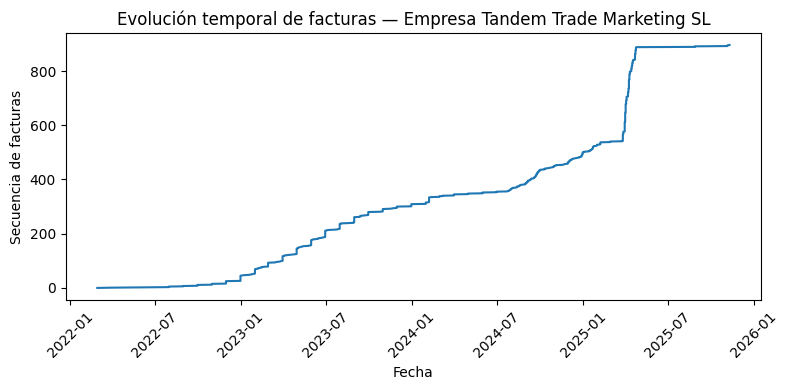

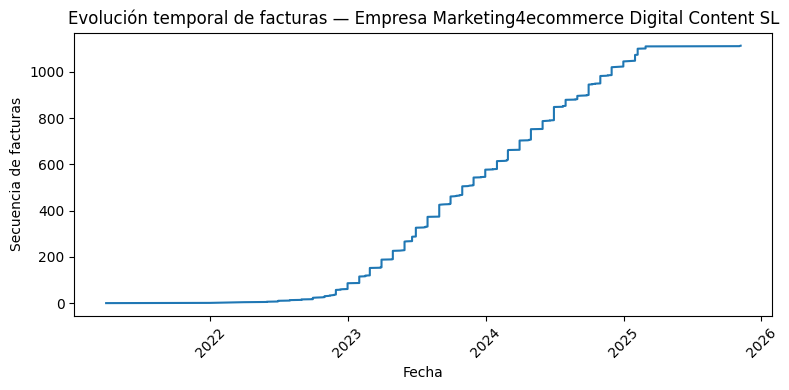

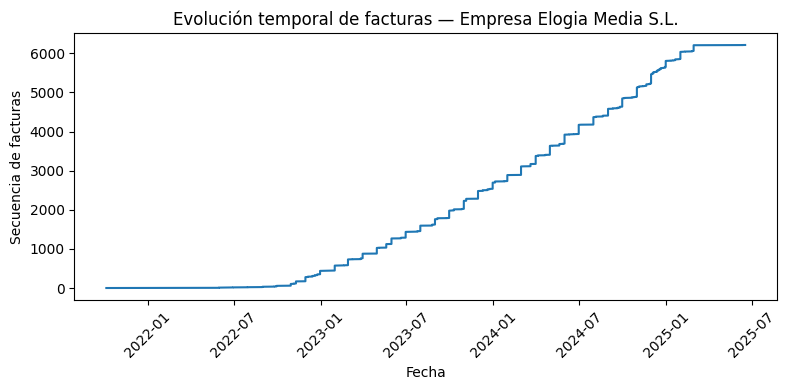

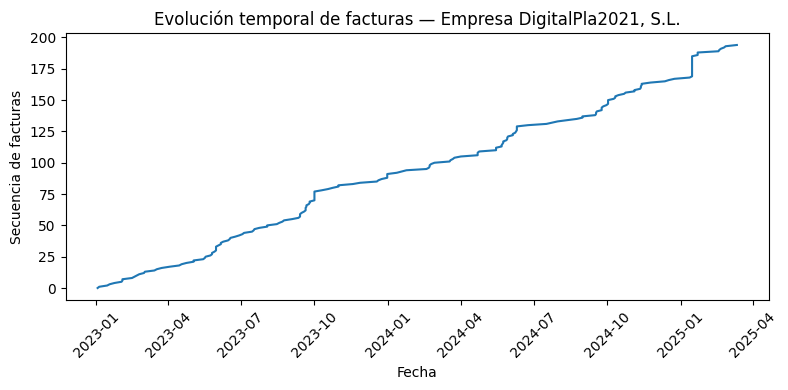

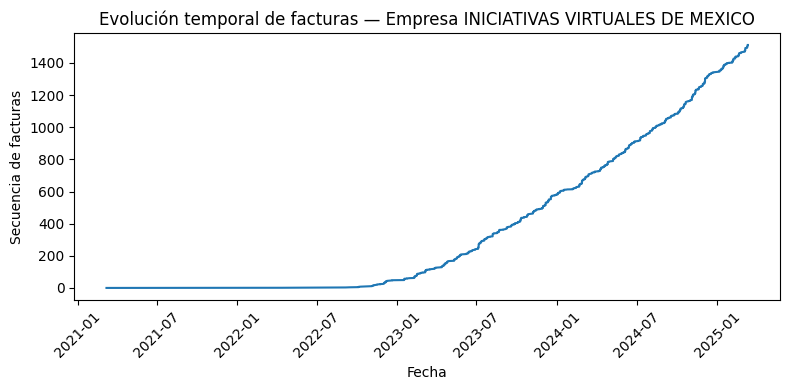

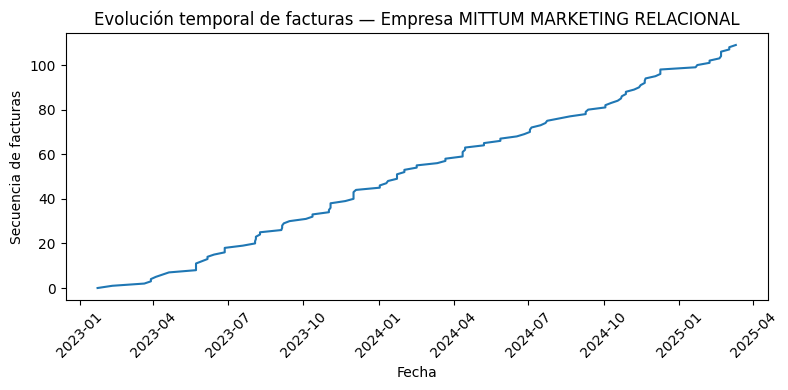

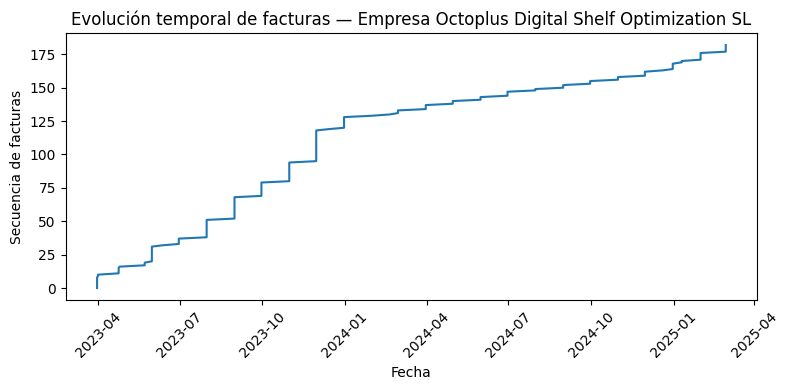

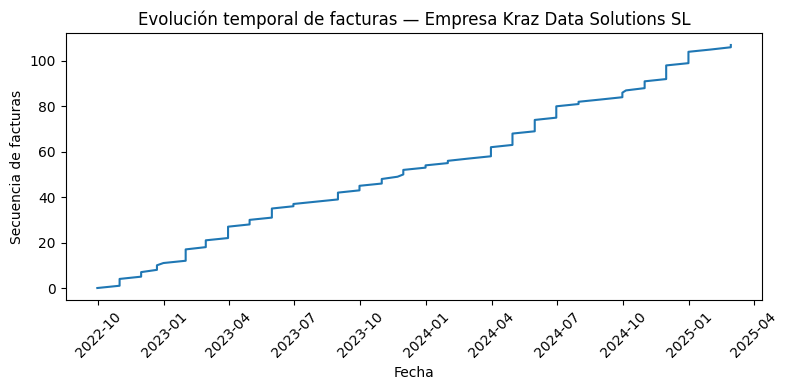

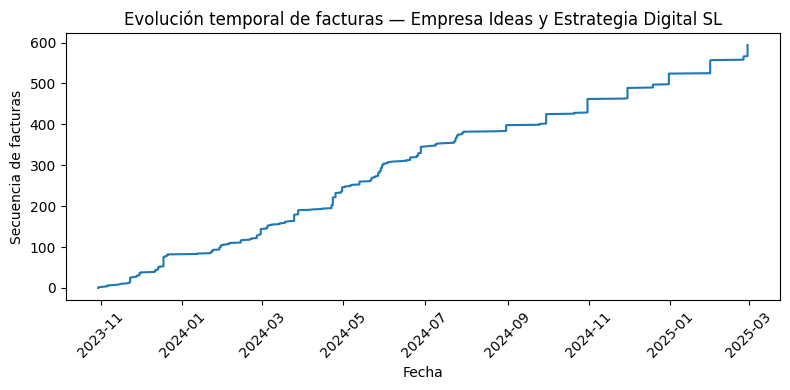

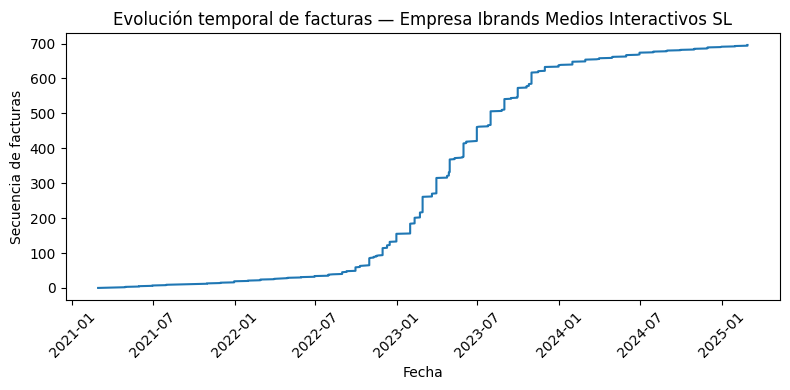

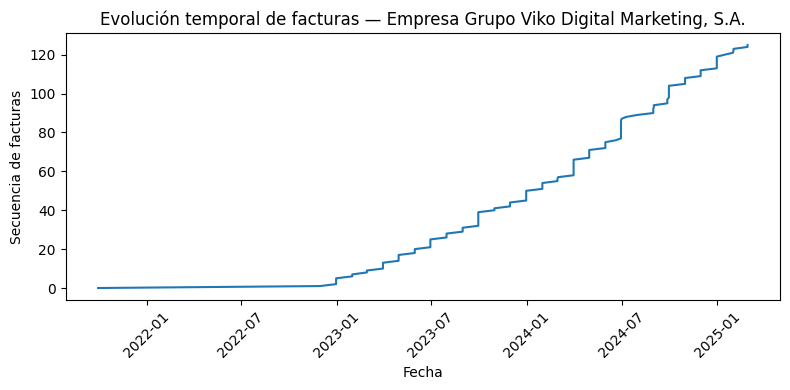

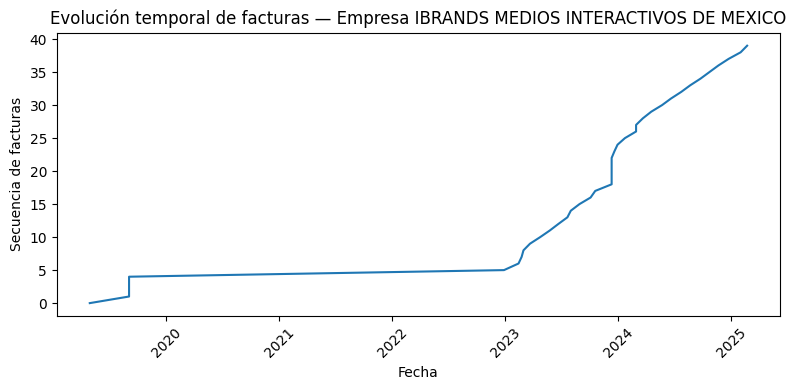

In [42]:
for company in invoices_df['company_id'].unique():
    subset = invoices_df[invoices_df['company_id'] == company].sort_values('invoice_date')
    plt.figure(figsize=(8, 4))
    plt.plot(subset['invoice_date'], range(len(subset)))
    plt.title(f"Evolución temporal de facturas — Empresa {company_df[company_df['id'] == company]['name'].values[0]}")
    plt.xlabel("Fecha")
    plt.ylabel("Secuencia de facturas")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Parece que hay algunas empresas que tienen facturas hasta octubre de 2025, mientrás que la mayoría tienen hasta finales de febrero - principios de marzo~, mirando datos cogeré la fecha 12-03-2025 como corte

In [58]:
mask = (invoices_df['invoice_date_due'] <= np.datetime64('2025-03-12')) | (invoices_df['payment_state']  == 'paid')
invoices_df = invoices_df[mask]

In [65]:
invoices_df.to_pickle("invoices_cleanedv9.pkl")

In [66]:
paid_invoices_df = invoices_df[invoices_df['payment_state'] == 'paid']
paid_invoices_df.to_pickle("paid_invoices.pkl")

Eliminaré las facturas con pago immediato, no sirven para el problema

In [74]:
mask = (paid_invoices_df['invoice_date_due'] == paid_invoices_df['invoice_date']) & (paid_invoices_df['invoice_date_due'] == paid_invoices_df['payment_dates'])
paid_invoices_df = paid_invoices_df[~mask]

Añadiré característica para saber cuántos días se ha pagado tarde

In [67]:
paid_invoices_df['payment_overdue_days'] = (paid_invoices_df['payment_dates'] - paid_invoices_df['invoice_date_due']).dt.days.clip(lower=0)

C:\Users\Ismae\AppData\Local\Temp\ipykernel_27628\1535626566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_invoices_df['payment_overdue_days'] = (paid_invoices_df['payment_dates'] - paid_invoices_df['invoice_date_due']).dt.days.clip(lower=0)


In [75]:
paid_invoices_df['payment_overdue_days'].describe()

count   10348.000
mean       21.721
std        67.228
min         0.000
25%         0.000
50%         1.000
75%        17.000
max      1486.000
Name: payment_overdue_days, dtype: float64

Tenemos outliers, comprobaré la distribución:

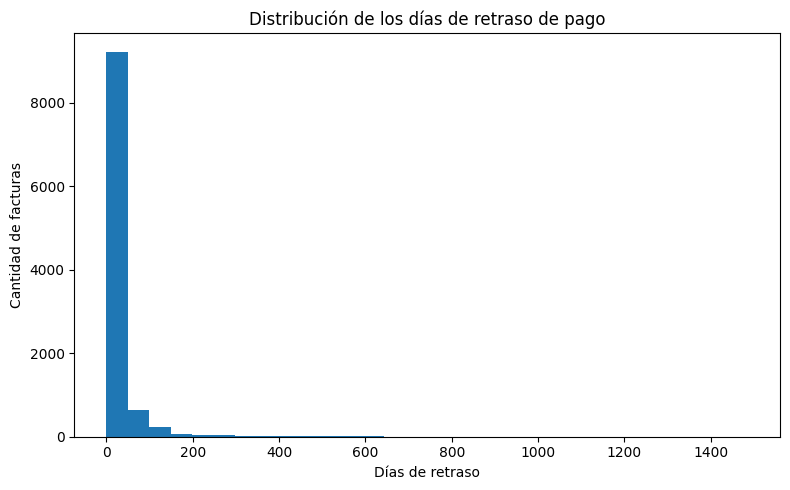

In [79]:
plt.figure(figsize=(8,5))
plt.hist(paid_invoices_df['payment_overdue_days'], bins=30)
plt.xlabel("Días de retraso")
plt.ylabel("Cantidad de facturas")
plt.title("Distribución de los días de retraso de pago")
plt.tight_layout()
plt.show()

Elimnaré el 0,5% de las facturas con días de retraso más altos, mirando los datos parecen ser errores

In [95]:
paid_invoices_df = paid_invoices_df[paid_invoices_df['payment_overdue_days'] <= paid_invoices_df['payment_overdue_days'].quantile(0.995)]
paid_invoices_df['payment_overdue_days'].describe()

count   10296.000
mean       18.326
std        43.240
min         0.000
25%         0.000
50%         1.000
75%        17.000
max       439.000
Name: payment_overdue_days, dtype: float64

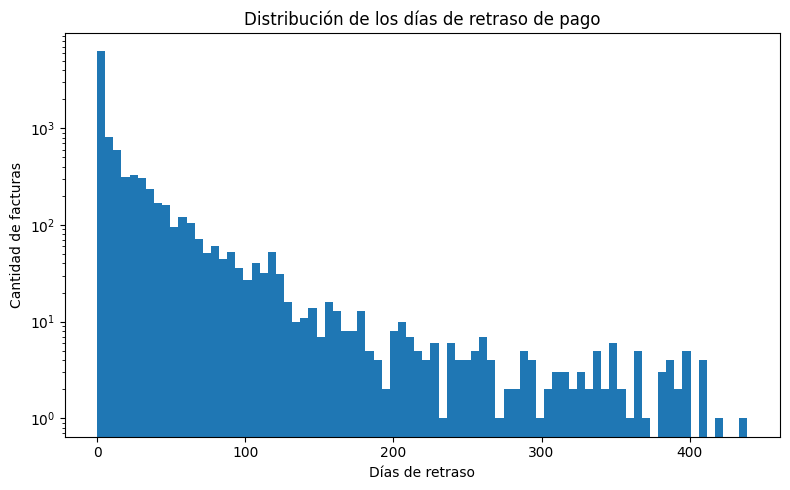

In [138]:
plt.figure(figsize=(8,5))
plt.hist(paid_invoices_df['payment_overdue_days'], bins=80, log=True)
plt.xlabel("Días de retraso")
plt.ylabel("Cantidad de facturas")
plt.title("Distribución de los días de retraso de pago")
plt.tight_layout()
plt.show()

Tiene una distribución sesgada a la derecha (right-skewed)

In [105]:
paid_in_time = paid_invoices_df[paid_invoices_df['payment_overdue_days'] == 0]
paid_late = paid_invoices_df[paid_invoices_df['payment_overdue_days'] > 0 ] 
print(f"Facturas pagadas a tiempo: {len(paid_in_time)}")
print(f"Facturas pagadas con retraso: {len(paid_late)}")      

Facturas pagadas a tiempo: 5003
Facturas pagadas con retraso: 5293


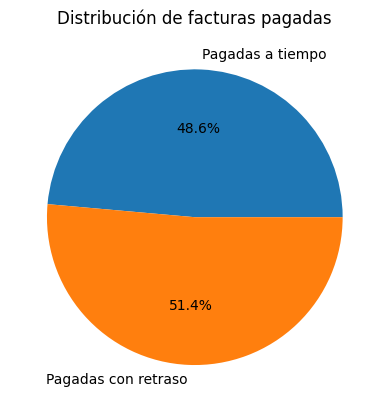

In [6]:
import matplotlib.pyplot as plt

labels = ["Pagadas a tiempo", "Pagadas con retraso"]
values = [5003, 5293]

plt.figure()
plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Distribución de facturas pagadas")
plt.show()


Bastante balanceado, la mitad de facturas se pagan a tiempo, la otra mitad no

In [ ]:
paid_invoices_df.to_pickle("paid_invoicesv1.pkl")   

Miraré por empresas:

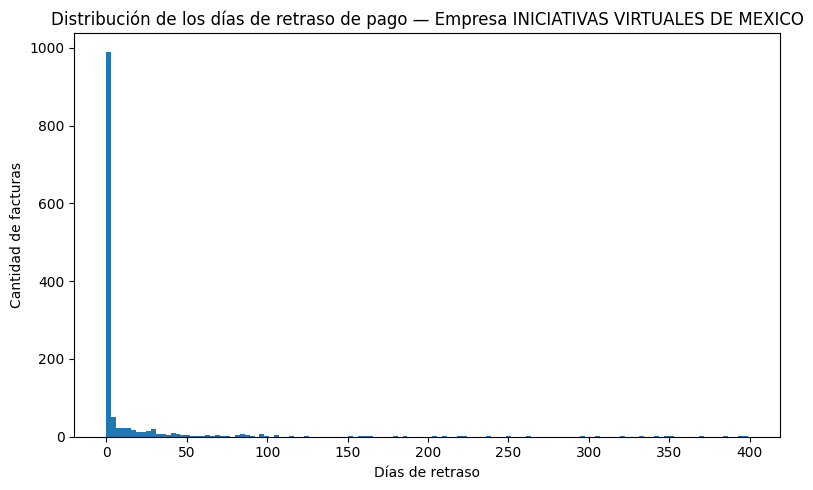

Días de retraso promedio: 13.61
Facturas pagadas a tiempo: 948
Facturas pagadas con retraso: 369


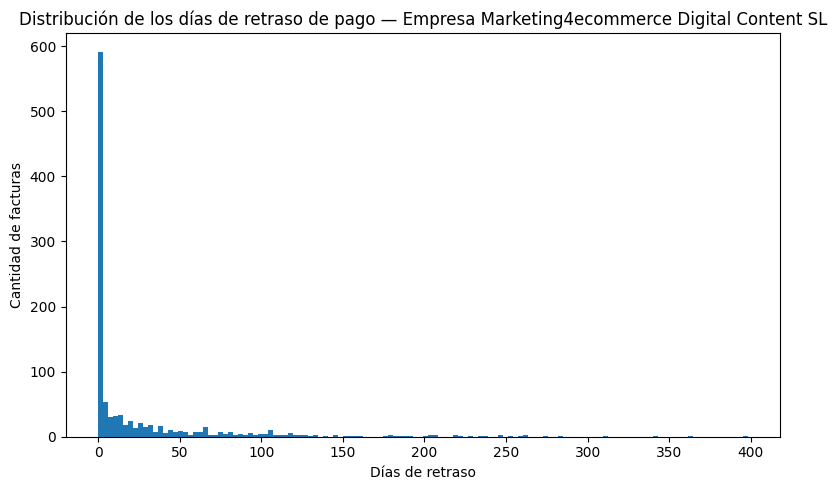

Días de retraso promedio: 24.01
Facturas pagadas a tiempo: 515
Facturas pagadas con retraso: 552


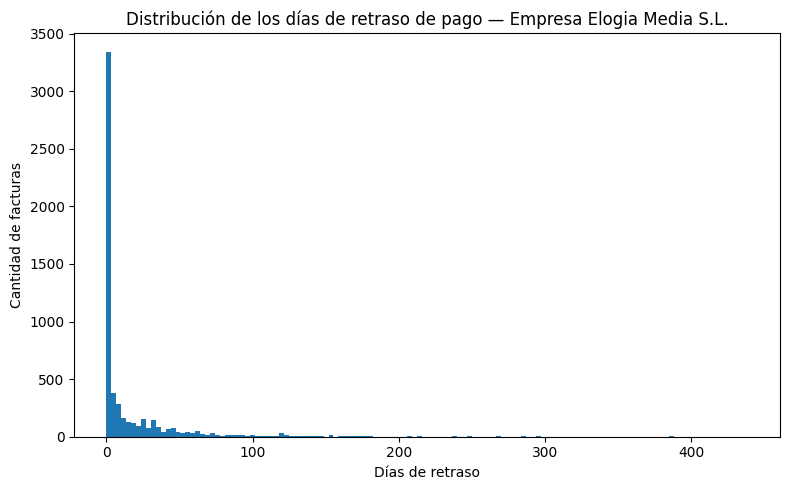

Días de retraso promedio: 16.02
Facturas pagadas a tiempo: 2815
Facturas pagadas con retraso: 2900


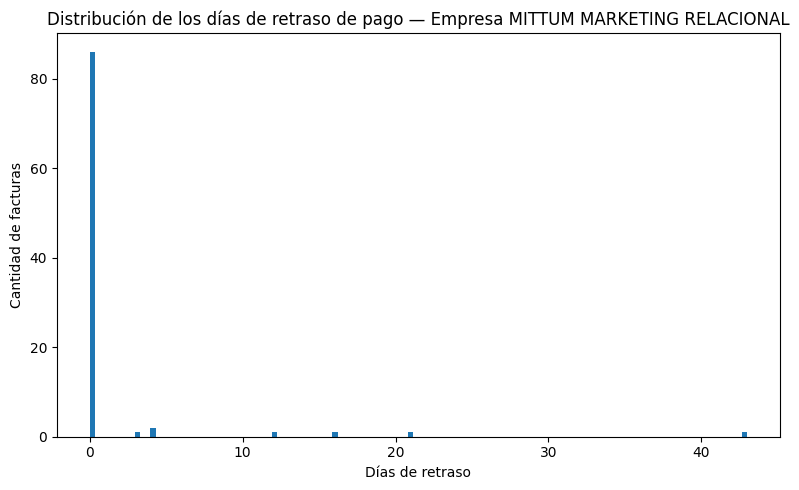

Días de retraso promedio: 1.11
Facturas pagadas a tiempo: 86
Facturas pagadas con retraso: 7


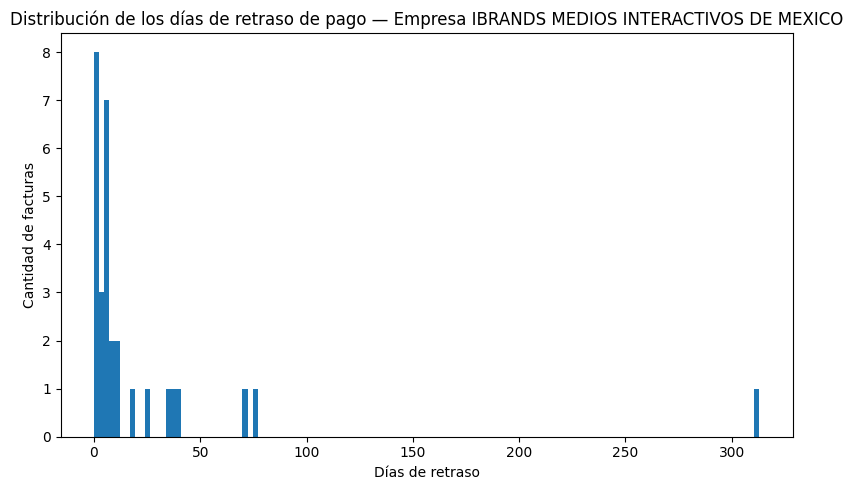

Días de retraso promedio: 23.53
Facturas pagadas a tiempo: 7
Facturas pagadas con retraso: 23


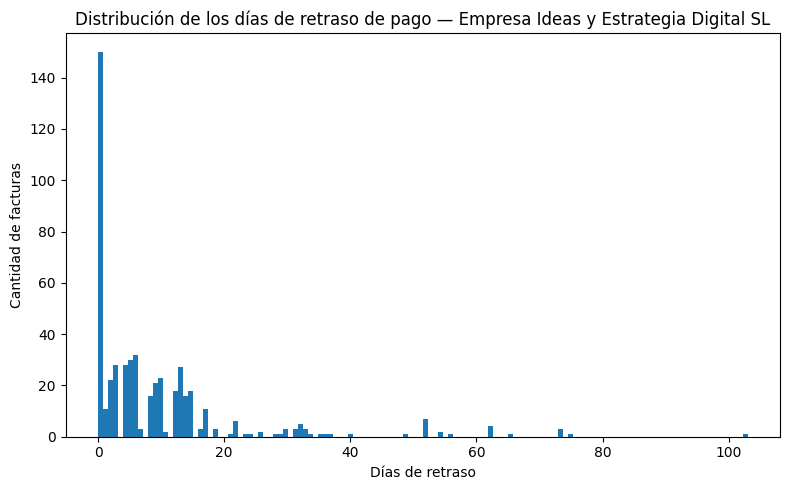

Días de retraso promedio: 9.23
Facturas pagadas a tiempo: 150
Facturas pagadas con retraso: 365


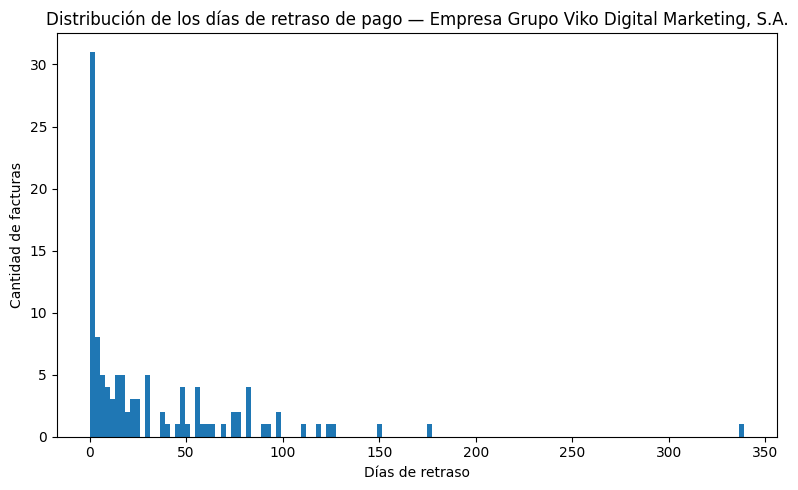

Días de retraso promedio: 33.26
Facturas pagadas a tiempo: 24
Facturas pagadas con retraso: 86


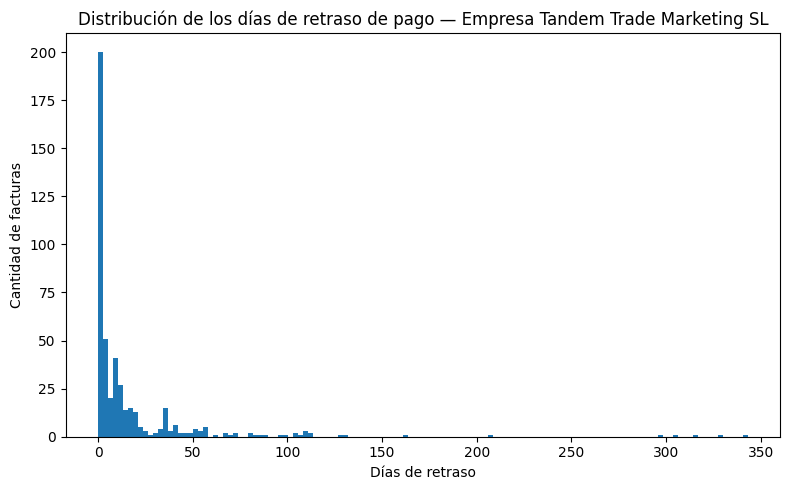

Días de retraso promedio: 17.39
Facturas pagadas a tiempo: 152
Facturas pagadas con retraso: 316


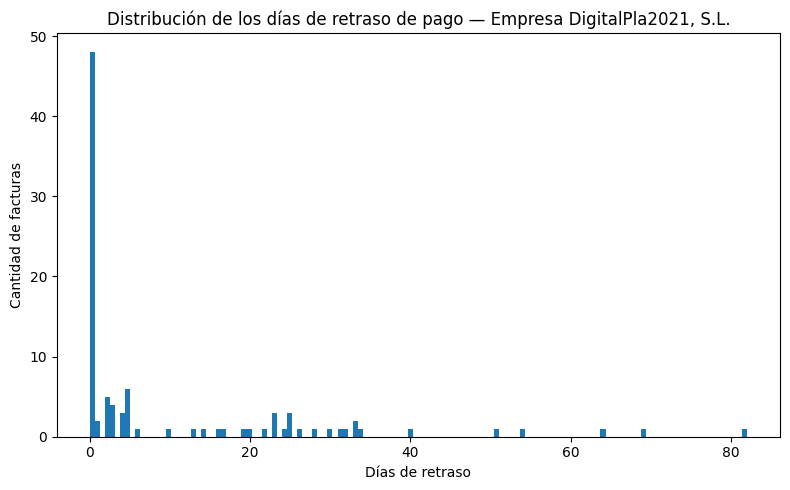

Días de retraso promedio: 9.98
Facturas pagadas a tiempo: 48
Facturas pagadas con retraso: 50


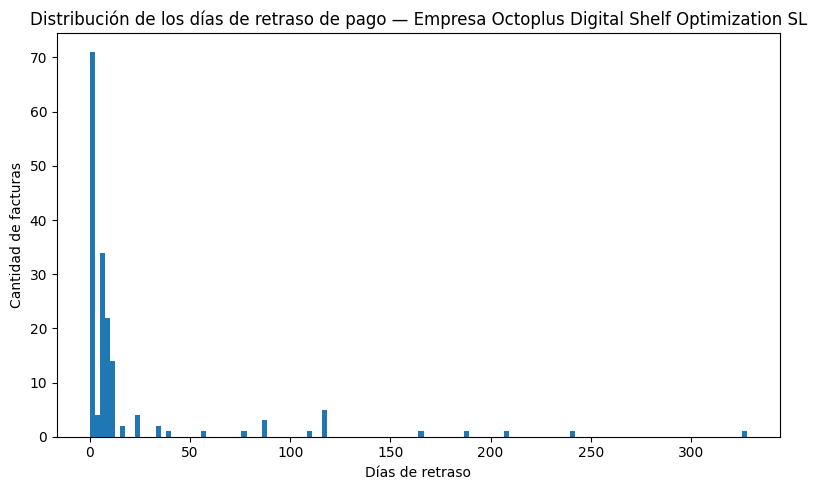

Días de retraso promedio: 18.05
Facturas pagadas a tiempo: 55
Facturas pagadas con retraso: 115


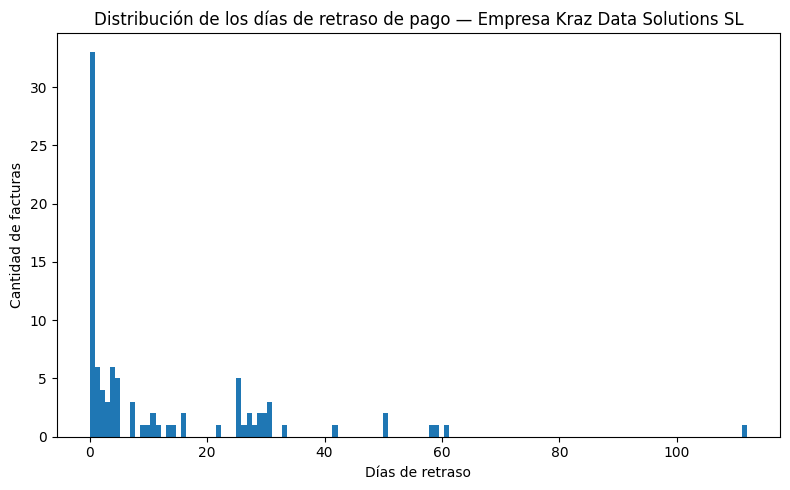

Días de retraso promedio: 12.09
Facturas pagadas a tiempo: 33
Facturas pagadas con retraso: 61


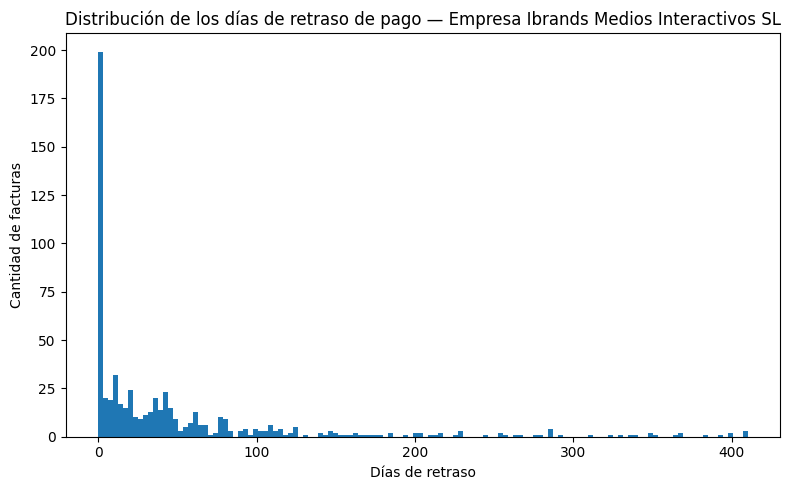

Días de retraso promedio: 50.10
Facturas pagadas a tiempo: 170
Facturas pagadas con retraso: 449


In [108]:
for company in paid_invoices_df['company_id'].unique():
    subset = paid_invoices_df[paid_invoices_df['company_id'] == company].sort_values('invoice_date')
    plt.figure(figsize=(8,5))
    plt.hist(subset['payment_overdue_days'], bins=130)
    plt.xlabel("Días de retraso")
    plt.ylabel("Cantidad de facturas")
    plt.title(f"Distribución de los días de retraso de pago — Empresa {company_df[company_df['id'] == company]['name'].values[0]}")
    plt.tight_layout()
    plt.show()
    print(f"Días de retraso promedio: {subset['payment_overdue_days'].mean():.2f}")
    print(f'Facturas pagadas a tiempo: {len(subset[subset['payment_overdue_days'] == 0])}')
    print(f'Facturas pagadas con retraso: {len(subset[subset['payment_overdue_days'] > 0])}')

Nada destacable, todas las empresas tienen facturas pagadas tarde, más o menos, y con diferentes promedios, ibrands medios interactivos tiene una concetración mayor de facturas pagadas con retraso

Miraré la distribución de los importes de las facturas

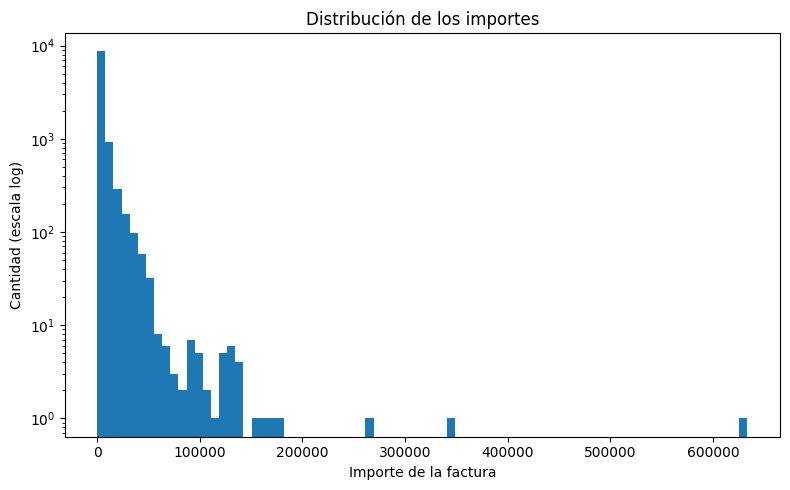

In [118]:
plt.figure(figsize=(8,5))
plt.hist(paid_invoices_df['amount_total_eur'].dropna(), bins=80, log=True)
plt.xlabel("Importe de la factura")
plt.ylabel("Cantidad (escala log)")
plt.title("Distribución de los importes")
plt.tight_layout()
plt.show()

Gran concetración de facturas pequeñas, con algunas facturas con importes muy altos, sigue una distribución sesgada a la derecha (right-skewed)

Miraré si hay correlación lineal entre importes y días de pago, normalizo los pagos debido a la gran diferencia entre importes

In [121]:
pearson = paid_invoices_df['amount_total_eur'].corr(paid_invoices_df['payment_overdue_days'], method='pearson')
pearson

np.float64(-0.01016020885380339)

Correlación monótona, más sentido

In [126]:
paid_invoices_df['log_amount_total_eur'] = np.log(paid_invoices_df['amount_total_eur'])
spaerman = paid_invoices_df['log_amount_total_eur'].corr(paid_invoices_df['payment_overdue_days'], method='spearman')
spaerman

np.float64(-0.007876198006716451)

No parece que haya correlación

Crearé intervalos de los días de pago, de momento 0 (puntual), 1-15 (leve), 16-30 (moderado), 31-60 (grave), >60 (muy grave)

Necesarios para clasificación

In [127]:
def payment_overdue_category(days):
    if days == 0:
        return 'Puntual'
    elif 1 <= days <= 15:
        return '1-15'
    elif 16 <= days <= 30:
        return '16-30'
    elif 31 <= days <= 60:
        return '31-60'
    else:
        return '>60'
paid_invoices_df['payment_overdue_category'] = paid_invoices_df['payment_overdue_days'].apply(payment_overdue_category)


In [129]:
paid_invoices_df.to_pickle("paid_invoicesv2.pkl")

In [128]:
paid_invoices_df['payment_overdue_category'].value_counts()

payment_overdue_category
Puntual    5003
1-15       2649
31-60       945
>60         871
16-30       828
Name: count, dtype: int64

Crearé una columna con los plazos de pago

Plazos que no tienen absolutamente ningún sentido...

In [133]:
paid_invoices_df['term'] = (paid_invoices_df['invoice_date_due'] - paid_invoices_df['invoice_date']).dt.days
paid_invoices_df['term'] = paid_invoices_df['term'].clip(lower=0)
paid_invoices_df['term_rounded'] = (paid_invoices_df['term'] / 10).round() * 10
paid_invoices_df['term_rounded'].value_counts()

term_rounded
60.000     3623
30.000     2916
50.000      860
40.000      711
0.000       517
20.000      423
80.000      331
70.000      322
10.000      212
90.000      166
110.000     142
120.000      31
100.000      28
170.000       6
140.000       4
130.000       2
150.000       1
210.000       1
Name: count, dtype: int64

Un poco sketchy la verdad, pero bueno, lo haré así por ahora

In [134]:
def map_term(x):
    if x <= 20:
        return 0
    elif x <= 40:
        return 30
    elif x <= 55:
        return 45
    elif x <= 75:
        return 60
    elif x <= 95:
        return 90
    else:
        return ">90"
paid_invoices_df['term_mapped'] = paid_invoices_df['term'].apply(map_term)
paid_invoices_df['term_mapped'].value_counts()

term_mapped
60     3911
30     3148
45     1467
0      1091
90      465
>90     214
Name: count, dtype: int64

Miraré si hay correlación, para ello primero convierto las categorias de formato categórico a ordinal

In [135]:
term_map = {0: 0, 30: 1, 45: 2, 60: 3, 90: 4, ">90": 5}
delay_map = {'Puntual': 0, '1-15': 1, '16-30': 2, '31-60': 3, '>60': 4}
paid_invoices_df['term_encoded'] = paid_invoices_df['term_mapped'].map(term_map)
paid_invoices_df['delay_encoded'] = paid_invoices_df['payment_overdue_category'].map(delay_map)

In [ ]:
spaerman = paid_invoices_df['term_encoded'].corr(paid_invoices_df['delay_encoded'], method='spearman')
spaerman

np.float64(-0.14054227170841704)

Relación demasiado débil como para tenerla en cuenta

Miraré ahora las variables numéricas restantes

In [140]:
paid_invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10296 entries, 2628 to 24287
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        10296 non-null  int64         
 1   name                      10296 non-null  object        
 2   move_type                 10296 non-null  object        
 3   payment_state             10296 non-null  object        
 4   company_id                10296 non-null  int64         
 5   partner_id                10296 non-null  object        
 6   currency_id               10296 non-null  int64         
 7   amount_total              10296 non-null  float64       
 8   amount_residual           10296 non-null  float64       
 9   invoice_date              10296 non-null  datetime64[ns]
 10  invoice_date_due          10296 non-null  datetime64[ns]
 11  payment_dates             10296 non-null  datetime64[ns]
 12  company_name        

Miraré la cantidad restante por pagar (tendria que ser 0 ya que tratamos con facturas pagadas)

In [141]:
paid_invoices_df[['amount_residual_eur']].describe()

,amount_residual_eur
count,10296.000
mean,0.001
std,0.059
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,6.000


In [142]:
paid_invoices_df[paid_invoices_df['amount_residual_eur'] > 0]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,amount_total,amount_residual,invoice_date,...,amount_total_eur,amount_residual_eur,payment_overdue_days,log_amount_total_eur,payment_overdue_category,term,term_rounded,term_mapped,term_encoded,delay_encoded
5109,174403,FVE/2024/03004,out_invoice,paid,3,13260,1,6980.290,0.010,2024-12-31,...,6980.290,0.010,1,8.851,1-15,14,10.000,0,0,1
10452,149233,FVE/2024/02077,out_invoice,paid,3,8527,1,1394.580,0.010,2024-09-30,...,1394.580,0.010,0,7.240,Puntual,61,60.000,60,3,0
12124,139026,ELM202400377,out_invoice,paid,8,12056,33,376924.090,0.090,2024-08-14,...,17810.040,0.004,0,9.788,Puntual,30,30.000,30,1,0
15041,104262,FVE/2024/00656,out_invoice,paid,3,8369,1,7456.070,0.050,2024-03-31,...,7456.070,0.050,11,8.917,1-15,60,60.000,60,3,1
21310,47707,FVE/2023/00842,out_invoice,paid,3,8547,1,7890.000,6.000,2023-06-20,...,7890.000,6.000,109,8.973,>60,61,60.000,60,3,4


Valores demasiado pequeños excepto en el caso de la factura 47707

In [143]:
invoice_lines = pd.read_pickle("invoice_lines.pkl")
invoice_lines[invoice_lines['move_id'] == 47707]


,id,move_id,product_id,quantity,price_unit,tax_ids,reconciled,blocked,date_maturity,debit,credit,balance,amount_residual,currency_id,company_id,discount,discount_percentage,full_reconcile_id,is_downpayment,reconcile_model_id


No hay lineas de factura, asumiré que es a causa de que es muy antigua y la contaré como pagada

Elimino columnas que no sirven ya

In [ ]:
paid_invoices_df = paid_invoices_df.drop(columns=['log_amount_total_eur', 'amount_residual', 'amount_total'])
paid_invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10296 entries, 2628 to 24287
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        10296 non-null  int64         
 1   name                      10296 non-null  object        
 2   move_type                 10296 non-null  object        
 3   payment_state             10296 non-null  object        
 4   company_id                10296 non-null  int64         
 5   partner_id                10296 non-null  object        
 6   currency_id               10296 non-null  int64         
 7   invoice_date              10296 non-null  datetime64[ns]
 8   invoice_date_due          10296 non-null  datetime64[ns]
 9   payment_dates             10296 non-null  datetime64[ns]
 10  company_name              10296 non-null  object        
 11  partner_name              10296 non-null  object        
 12  currency_name       

Comenzaré a ver las categóricas

In [145]:
paid_invoices_df['company_id'].value_counts()

company_id
3     5715
8     1317
6     1067
2      619
14     515
7      468
13     170
1      110
11      98
5       94
9       93
12      30
Name: count, dtype: int64

La mayoria de facturas vienen de la empresa 3

In [147]:
paid_invoices_df['partner_id'].value_counts().head(20)

partner_id
8920     555
8679     351
8527     205
8870     186
8153     180
9399     146
8663     141
9308     136
10389    133
8933     130
7538     129
7498     127
13557    117
7515     105
13548     97
7421      97
13558     96
10590     93
8996      89
7461      89
Name: count, dtype: int64

Algunos clientes con muchas facturas

In [151]:
paid_invoices_df.to_pickle("paid_invoicesv3.pkl")

TODO: late payment rate per category

### Partners

In [156]:
partners_df = pd.read_pickle("partners_cleanedv4.pkl")
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1321 entries, 0 to 1630
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1321 non-null   int64  
 1   name                1321 non-null   object 
 2   street              1318 non-null   object 
 3   city                1298 non-null   object 
 4   zip                 1302 non-null   object 
 5   credit              1321 non-null   float64
 6   vat                 1321 non-null   object 
 7   invoice_ids         1321 non-null   object 
 8   total_invoiced      1321 non-null   float64
 9   country_name        1321 non-null   object 
 10  total_invoiced_eur  1321 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 123.8+ KB


In [163]:
partners_df['invoice_ids'] = partners_df['invoice_ids'].apply(lambda x: [])
partners_df = partners_df.drop(columns=['total_invoiced'])

Actualizo las facturas de los clientes y los totales

In [164]:
for partner_id in partners_df['id']:
    invoices_partner = paid_invoices_df[paid_invoices_df['partner_id'] == partner_id]
    invoice_ids_list = invoices_partner['id'].tolist()
    partners_df.loc[partners_df['id'] == partner_id, 'invoice_ids'].iloc[0].extend(invoice_ids_list)
    partners_df.loc[partners_df['id'] == partner_id, 'total_invoiced_eur'] = invoices_partner['amount_total_eur'].sum()




    

Elimino clientes sin facturas

In [168]:
partners_df = partners_df.drop(partners_df[partners_df['total_invoiced_eur'] == 0].index)

In [170]:
partners_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1223 entries, 0 to 1630
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1223 non-null   int64  
 1   name                1223 non-null   object 
 2   street              1220 non-null   object 
 3   city                1201 non-null   object 
 4   zip                 1207 non-null   object 
 5   credit              1223 non-null   float64
 6   vat                 1223 non-null   object 
 7   invoice_ids         1223 non-null   object 
 8   country_name        1223 non-null   object 
 9   total_invoiced_eur  1223 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 105.1+ KB


Añado características útiles

In [ ]:
partners_df['total_invoices'] = partners_df['invoice_ids'].apply(lambda x: len(x))
quantity_paid_late = len(paid_invoices_df[paid_invoices_df['payment_overdue_days'] > 0])
quantity_paid_on_time = len(paid_invoices_df[paid_invoices_df['payment_overdue_days'] == 0])
partners_df['paid_late_ratio'] = 0.0
partners_df['paid_on_time_ratio'] = 0.0
partners_df['avg_days_late'] = 0.0
for partner_id in partners_df['id']:
    # solo de las facturas pagadas con retraso
    invoices_partner_late = paid_invoices_df[(paid_invoices_df['partner_id'] == partner_id) & (paid_invoices_df['payment_overdue_days'] > 0)]
    invoices_partner_ontime = paid_invoices_df[(paid_invoices_df['partner_id'] == partner_id) & (paid_invoices_df['payment_overdue_days'] == 0)]
    quantity_paid_late_partner = len(invoices_partner_late)
    quantity_paid_on_time_partner = len(invoices_partner_ontime)
    partners_df.loc[partners_df['id'] == partner_id, 'paid_late_ratio'] = quantity_paid_late_partner / (quantity_paid_late_partner + quantity_paid_on_time_partner)
    partners_df.loc[partners_df['id'] == partner_id, 'paid_on_time_ratio'] = quantity_paid_on_time_partner / (quantity_paid_late_partner + quantity_paid_on_time_partner)
    avg_days_late = invoices_partner_late['payment_overdue_days'].mean()
    partners_df.loc[partners_df['id'] == partner_id, 'avg_days_late'] = avg_days_late
partners_df.loc[partners_df['avg_days_late'].isna(), 'avg_days_late'] = 0.0

In [177]:
partners_df

,id,name,street,city,zip,credit,vat,invoice_ids,country_name,total_invoiced_eur,total_invoices,paid_late_ratio,paid_on_time_ratio,avg_days_late
0,14516,200 Labs Inc,"490 Post St, Ste 526",San Francisco,94102,0.000,46-4595829,[173406],United States,1808.500,1,0.000,1.000,0.000
1,12500,"202 Digital Reputation, S.L.","C/ Tuset 19, entresuelo",Barcelona,08006,0.000,B06906226,[100844],Spain,726.000,1,0.000,1.000,0.000
2,10577,"2Be Confirmed Events, S.L.","C/ Doctor Fleming, 36",Madrid,28036,0.000,B86436243,[46745],Spain,605.000,1,1.000,0.000,7.000
3,12233,"2BeGroup&Partners, S.L.","Rua Das Baleras, 13 - 4 Oficina 5",Santiago de Compostela,15705,0.000,B70344619,"[150132, 83140, 83139]",Spain,2265.000,3,0.333,0.667,27.000
4,14539,"2 Open EU CN, S.L.U.","C/Sierpes, 3",Cáceres,10003,0.000,B10444545,[166006],Spain,726.000,1,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,8950,ZENSTAY,ANTILOPE MANZANA 12 LOTE 5 NUMERO 34 - D,CANCÚN,77500,0.000,ZEN201203GM3,"[166734, 166731, 153655, 119628, 96703, 80063,...",Mexico,21276.322,13,0.154,0.846,27.000
1627,9285,Zippy - Comercio e Distribuição SA,"Rua João Mendonça, nº 529",Senhora da Hora,4464-503,0.000,PT503226696,[11873],Portugal,2650.000,1,1.000,0.000,70.000
1628,11067,"Zoconet, S.L.","Avd. Juan López Peñalver, 17",Málaga,29590,0.000,B29853264,[58839],Spain,30.250,1,0.000,1.000,0.000
1629,14429,"Zumitow, S.L.","C/Pensamiento 27, Pta. 3, Esc. Izq.. Plt. 3",Madrid,28020,0.000,B56156581,[160887],Spain,1210.000,1,0.000,1.000,0.000


In [178]:
partners_df.to_pickle("partners_cleanedv5.pkl")

In [179]:
paid_invoices_df = pd.read_pickle("paid_invoicesv3.pkl")

### Dataset final

In [230]:
dataset = paid_invoices_df.copy()
dataset[['avg_invoiced_prior', 'num_prior_invoices', 'num_late_prior_invoices', 'ratio_late_prior_invoices', 
         'total_invoice_amount_prior', 'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior',
         'avg_delay_prior_late_invoices', 'avg_delay_prior_all', 'num_outstanding_invoices', 'num_outstanding_invoices_late'
         , 'ratio_outstanding_invoices_late', 'total_invoice_amount_outstanding', 'total_invoice_amount_outstanding_late',
         'ratio_invoice_amount_outstanding_late',
         'avg_payment_term_prior_invoices']] = 0.0


In [231]:
reversed_dataset = dataset.sort_values(by='invoice_date', ascending=True).reset_index(drop=True)
reversed_dataset

,id,name,move_type,payment_state,company_id,partner_id,currency_id,invoice_date,invoice_date_due,payment_dates,...,ratio_invoice_amount_late_prior,avg_delay_prior_late_invoices,avg_delay_prior_all,num_outstanding_invoices,num_outstanding_invoices_late,ratio_outstanding_invoices_late,total_invoice_amount_outstanding,total_invoice_amount_outstanding_late,ratio_invoice_amount_outstanding_late,avg_payment_term_prior_invoices
0,12035,INV1/2022/00456,out_invoice,paid,3,9271,1,2021-10-05,2022-02-02,2023-01-04,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,11237,INV1/2022/00145,out_invoice,paid,2,8901,1,2022-01-31,2022-03-20,2023-03-06,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,12193,INV1/2022/00048,out_invoice,paid,7,7668,1,2022-02-28,2022-03-30,2023-02-21,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,10419,INV1/2022/00090,out_invoice,paid,6,8250,1,2022-02-28,2022-03-17,2023-03-15,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,12192,INV1/2022/00047,out_invoice,paid,7,7668,1,2022-03-31,2022-04-30,2023-02-21,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,193014,FVE/2025/00246,out_invoice,paid,3,12263,1,2025-02-28,2025-02-28,2024-12-16,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10292,189617,FVE/2025/00235,out_invoice,paid,3,8503,1,2025-02-28,2025-03-30,2025-03-10,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10293,189612,FVE/2025/00230,out_invoice,paid,3,10200,1,2025-02-28,2025-03-30,2025-03-06,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10294,189376,FVM/2025/00059,out_invoice,paid,6,14813,2,2025-02-28,2025-03-30,2025-03-07,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [232]:
dataset[['due_last_three_days_month', 'due_date_second_half_month']] = False

In [233]:
invoices_df = pd.read_pickle("invoices_cleanedv9.pkl")
unpaid_invoices_df = invoices_df[invoices_df['payment_state'] != 'paid']

In [234]:
# 'num_outstanding_invoices', 'num_outstanding_invoices_late',  'ratio_outstanding_invoices_late', 'total_invoice_amount_outstanding', 'total_invoice_amount_outstanding_late', pendiente de facturas impagadas
# 'ratio_invoice_amount_outstanding_late'

grouped_partner = reversed_dataset.groupby("partner_id")
for index, row in reversed_dataset.iterrows():
    partner_id = row['partner_id']
    id = row['id']
    
    invoices_partner = grouped_partner.get_group(partner_id)
    prior_invoices_partner = invoices_partner[invoices_partner['invoice_date'] < row['invoice_date']]
    late_prior_invoices_partner = prior_invoices_partner[prior_invoices_partner['payment_overdue_days'] > 0]
    if len(prior_invoices_partner) > 0:
        dataset.loc[dataset["id"] == id, 'avg_invoiced_prior'] = prior_invoices_partner['amount_total_eur'].mean()
        dataset.loc[dataset["id"] == id, 'num_prior_invoices'] = len(prior_invoices_partner)
        dataset.loc[dataset["id"] == id, 'total_invoice_amount_prior'] = prior_invoices_partner['amount_total_eur'].sum()
        if len(late_prior_invoices_partner) > 0:
            dataset.loc[dataset["id"] == id, 'num_late_prior_invoices'] = len(late_prior_invoices_partner)
            dataset.loc[dataset["id"] == id, 'ratio_late_prior_invoices'] = len(late_prior_invoices_partner) / len(prior_invoices_partner)
            dataset.loc[dataset["id"] == id, 'total_invoice_amount_late_prior'] = late_prior_invoices_partner['amount_total_eur'].sum()
            dataset.loc[dataset["id"] == id, 'ratio_invoice_amount_late_prior'] = late_prior_invoices_partner['amount_total_eur'].sum() / prior_invoices_partner['amount_total_eur'].sum()
            dataset.loc[dataset["id"] == id, 'avg_delay_prior_late_invoices'] = late_prior_invoices_partner['payment_overdue_days'].mean()
            dataset.loc[dataset["id"] == id, 'avg_delay_prior_all'] = prior_invoices_partner['payment_overdue_days'].mean()
            due_day = row['invoice_date_due'].day
            month = row['invoice_date_due'].month
            year = row['invoice_date_due'].year
            # sumo 1 mees, resto un dia y obtengo el ultimo dia del mes original
            days_in_month = (pd.Timestamp(year, month % 12 + 1, 1) - pd.Timedelta(days=1)).day 
            if due_day > days_in_month - 3:
                dataset.loc[dataset["id"] == id, 'due_last_three_days_month'] = True
            if due_day > 15:
                dataset.loc[dataset["id"] == id, 'due_date_second_half_month'] = True
            dataset.loc[dataset["id"] == id, 'avg_payment_term_prior_invoices'] = prior_invoices_partner['term'].mean()
            # pendiente de facturas impagadas
    outstanding_invoices_partner = unpaid_invoices_df[(unpaid_invoices_df['partner_id'] == partner_id) & (unpaid_invoices_df['invoice_date'] < row['invoice_date'])]
    if len(outstanding_invoices_partner) > 0:
        dataset.loc[dataset["id"] == id, 'num_outstanding_invoices'] = len(outstanding_invoices_partner)
        late_outstanding_invoices_partner = outstanding_invoices_partner[outstanding_invoices_partner['invoice_date_due'] < pd.Timestamp(2025, 3, 12)]
        if len(late_outstanding_invoices_partner) > 0:
            dataset.loc[dataset["id"] == id, 'num_outstanding_invoices_late'] = len(late_outstanding_invoices_partner)
            dataset.loc[dataset["id"] == id, 'ratio_outstanding_invoices_late'] = len(late_outstanding_invoices_partner) / len(outstanding_invoices_partner)
            dataset.loc[dataset["id"] == id, 'total_invoice_amount_outstanding'] = outstanding_invoices_partner['amount_total_eur'].sum()
            dataset.loc[dataset["id"] == id, 'total_invoice_amount_outstanding_late'] = late_outstanding_invoices_partner['amount_total_eur'].sum()
            dataset.loc[dataset["id"] == id, 'ratio_invoice_amount_outstanding_late'] = late_outstanding_invoices_partner['amount_total_eur'].sum() / outstanding_invoices_partner['amount_total_eur'].sum()

In [235]:
dataset[['avg_invoiced_prior', 'num_prior_invoices', 'num_late_prior_invoices', 'ratio_late_prior_invoices', 
         'total_invoice_amount_prior', 'total_invoice_amount_late_prior', 'ratio_invoice_amount_late_prior',
         'avg_delay_prior_late_invoices', 'avg_delay_prior_all', 'num_outstanding_invoices', 'num_outstanding_invoices_late'
         , 'ratio_outstanding_invoices_late', 'total_invoice_amount_outstanding', 'total_invoice_amount_outstanding_late',
         'ratio_invoice_amount_outstanding_late']].describe()

,avg_invoiced_prior,num_prior_invoices,num_late_prior_invoices,ratio_late_prior_invoices,total_invoice_amount_prior,total_invoice_amount_late_prior,ratio_invoice_amount_late_prior,avg_delay_prior_late_invoices,avg_delay_prior_all,num_outstanding_invoices,num_outstanding_invoices_late,ratio_outstanding_invoices_late,total_invoice_amount_outstanding,total_invoice_amount_outstanding_late,ratio_invoice_amount_outstanding_late
count,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000,10296.000
mean,4837.111,41.346,20.125,0.500,237489.695,139993.872,0.515,27.166,20.226,0.150,0.150,0.076,643.826,643.826,0.076
std,6512.231,79.540,35.849,0.395,483016.477,331087.961,0.402,43.593,37.986,0.827,0.827,0.265,4051.076,4051.076,0.265
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,594.969,3.000,1.000,0.075,3499.850,158.952,0.052,1.227,0.403,0.000,0.000,0.000,0.000,0.000,0.000
50%,3333.923,12.000,5.000,0.544,34388.675,15229.090,0.578,12.073,5.106,0.000,0.000,0.000,0.000,0.000,0.000
75%,6100.192,40.000,20.000,0.909,229694.930,117579.510,0.960,35.429,24.381,0.000,0.000,0.000,0.000,0.000,0.000
max,139150.000,546.000,228.000,1.000,3820636.690,2425684.680,1.000,409.000,409.000,20.000,20.000,1.000,71251.000,71251.000,1.000


In [227]:
dataset['paid_late'] = dataset['payment_overdue_days'] > 0

In [228]:
dataset[['due_last_three_days_month', 'due_date_second_half_month', 'paid_late']].value_counts()

due_last_three_days_month  due_date_second_half_month  paid_late
False                      False                       False        2577
                                                       True         2280
True                       True                        True         1976
                                                       False        1587
False                      True                        True         1037
                                                       False         839
Name: count, dtype: int64

In [229]:
dataset.to_pickle("dataset.pkl")

In [ ]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10296 entries, 2628 to 24287
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id                                     10296 non-null  int64         
 1   name                                   10296 non-null  object        
 2   move_type                              10296 non-null  object        
 3   payment_state                          10296 non-null  object        
 4   company_id                             10296 non-null  int64         
 5   partner_id                             10296 non-null  object        
 6   currency_id                            10296 non-null  int64         
 7   invoice_date                           10296 non-null  datetime64[ns]
 8   invoice_date_due                       10296 non-null  datetime64[ns]
 9   payment_dates                          10296 non-null  datetime

In [13]:
dataset.loc[dataset['partner_id'] == 11535]

,id,name,move_type,payment_state,company_id,partner_id,currency_id,invoice_date,invoice_date_due,payment_dates,...,num_outstanding_invoices,num_outstanding_invoices_late,ratio_outstanding_invoices_late,total_invoice_amount_outstanding,total_invoice_amount_outstanding_late,ratio_invoice_amount_outstanding_late,avg_payment_term_prior_invoices,due_last_three_days_month,due_date_second_half_month,paid_late
2628,189225,M4C1202500008,out_invoice,paid,8,11535,33,2025-03-03,2025-04-03,2025-03-05,...,0.000,0.000,0.000,0.000,0.000,0.000,25.875,False,False,False
3097,179782,M4C1202500003,out_invoice,paid,8,11535,33,2025-02-04,2025-03-04,2025-02-05,...,0.000,0.000,0.000,0.000,0.000,0.000,25.571,False,False,False
5508,169117,ELM202400691,out_invoice,paid,8,11535,33,2024-12-27,2025-01-27,2024-12-27,...,0.000,0.000,0.000,0.000,0.000,0.000,24.667,False,True,False
8285,155790,M4C1202400089,out_invoice,paid,8,11535,33,2024-11-14,2024-12-14,2024-11-15,...,0.000,0.000,0.000,0.000,0.000,0.000,23.600,False,False,False
9916,149141,M4C1202400074,out_invoice,paid,8,11535,33,2024-10-09,2024-11-08,2024-10-09,...,0.000,0.000,0.000,0.000,0.000,0.000,22.000,False,False,False
10611,146393,M4C1202400068,out_invoice,paid,8,11535,33,2024-09-26,2024-10-25,2024-09-26,...,0.000,0.000,0.000,0.000,0.000,0.000,19.667,False,True,False
16704,80585,M4C1202400004,out_invoice,paid,8,11535,33,2024-01-03,2024-02-02,2024-01-04,...,0.000,0.000,0.000,0.000,0.000,0.000,14.500,False,False,False
17963,76631,M4C1202300083,out_invoice,paid,8,11535,33,2023-11-30,2023-12-29,2023-12-01,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,True,True,False
19346,70495,M4C1202300073,out_invoice,paid,8,11535,33,2023-10-25,2023-10-25,2023-10-31,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,False,False,True


In [16]:
csv_temp = dataset[dataset['num_outstanding_invoices_late'] > 0].head()
csv_temp.to_csv('temp.csv')

In [ ]:
y = dataset['payment_overdue_category']
x = dataset[['amount_total_eur', 'term', 'currency_name', 'company_name', 'partner_name', 'due_last_three_days_month', 'due_date_second_half_month']]